In [43]:
from scipy.io import wavfile

(source_fs, source_data) = wavfile.read('./data/2nd_experiment/source.wav')

(target_fs, target_ll_data) = wavfile.read('./data/2nd_experiment/ll.wav')
(target_fs, target_ml_data) = wavfile.read('./data/2nd_experiment/ml.wav')
(target_fs, target_hl_data) = wavfile.read('./data/2nd_experiment/hl.wav')

(target_fs, target_lm_data) = wavfile.read('./data/2nd_experiment/lm.wav')
(target_fs, target_mm_data) = wavfile.read('./data/2nd_experiment/mm.wav')
(target_fs, target_hm_data) = wavfile.read('./data/2nd_experiment/hm.wav')

(target_fs, target_ll_lm_data) = wavfile.read('./data/2nd_experiment/ll_lm.wav')
(target_fs, target_hl_hm_data) = wavfile.read('./data/2nd_experiment/hl_hm.wav')

In [44]:
import pandas as pd

In [45]:
source_df = pd.DataFrame(source_data, columns=['L', 'R'])['L']

target_ll_df = pd.DataFrame(target_ll_data, columns=['L', 'R'])['L']
target_ml_df = pd.DataFrame(target_ml_data, columns=['L', 'R'])['L']
target_hl_df = pd.DataFrame(target_hl_data, columns=['L', 'R'])['L']

target_lm_df = pd.DataFrame(target_lm_data, columns=['L', 'R'])['L']
target_mm_df = pd.DataFrame(target_mm_data, columns=['L', 'R'])['L']
target_hm_df = pd.DataFrame(target_hm_data, columns=['L', 'R'])['L']

target_ll_lm_df = pd.DataFrame(target_ll_lm_data, columns=['L', 'R'])['L']
target_hl_hm_df = pd.DataFrame(target_hl_hm_data, columns=['L', 'R'])['L']

(
    source_df.max(),
    target_ll_df.max(), target_ml_df.max(), target_hl_df.max(),
    target_lm_df.max(), target_mm_df.max(), target_hm_df.max(),
    target_ll_lm_df.max(), target_hl_hm_df.max(),
)

(28421, 24199, 23898, 24171, 23374, 24156, 24364, 21997, 24348)

In [46]:
MAX_VALUE = 2 ** 15 - 1
MAX_VALUE

32767

In [47]:
(
    len(source_df),
    len(target_ll_df), len(target_ml_df), len(target_hl_df),
    len(target_lm_df), len(target_mm_df), len(target_hm_df),
    len(target_ll_lm_df), len(target_hl_hm_df),
)

(1669016,
 1669016,
 1669016,
 1669016,
 1669016,
 1669016,
 1669016,
 1669016,
 1669016)

## Data processing

In [48]:
N_TRAIN = 44000
N_TEST = 44000 * 2
N_TRAIN, N_TEST

(44000, 88000)

In [49]:
import numpy as np

In [50]:
# Adding knobs features

X_train_raw_ll = pd.Series(list(map(lambda x: [x,  0.0, 5.0], source_df[:N_TRAIN])))
X_train_raw_ml = pd.Series(list(map(lambda x: [x,  5.0, 5.0], source_df[:N_TRAIN])))
X_train_raw_hl = pd.Series(list(map(lambda x: [x, 10.0, 5.0], source_df[:N_TRAIN])))

X_train_raw_lm = pd.Series(list(map(lambda x: [x, 5.0,  0.0], source_df[:N_TRAIN])))
X_train_raw_mm = pd.Series(list(map(lambda x: [x, 5.0,  5.0], source_df[:N_TRAIN])))
X_train_raw_hm = pd.Series(list(map(lambda x: [x, 5.0, 10.0], source_df[:N_TRAIN])))

(
    len(X_train_raw_ll), len(X_train_raw_ml), len(X_train_raw_hl),
    len(X_train_raw_lm), len(X_train_raw_mm), len(X_train_raw_hm),
)

(44000, 44000, 44000, 44000, 44000, 44000)

In [51]:
X_test_raw_ll_lm = pd.Series(list(map(lambda x: [x, 0.0,  0.0], source_df[:N_TEST])))
X_test_raw_hl_hm = pd.Series(list(map(lambda x: [x, 10.0, 10.0], source_df[:N_TEST])))

len(X_test_raw_ll_lm), len(X_test_raw_hl_hm)

(88000, 88000)

In [52]:
# y_train_raw = np.concatenate([
#     target_lg_df['L'][:TR_END_LOC],
#     target_mg_df['L'][:TR_END_LOC],
#     target_hg_df['L'][:TR_END_LOC]
# ])

y_train_raw_ll = pd.Series(target_ll_df[:N_TRAIN])
y_train_raw_ml = pd.Series(target_ml_df[:N_TRAIN])
y_train_raw_hl = pd.Series(target_hl_df[:N_TRAIN])

y_train_raw_lm = pd.Series(target_lm_df[:N_TRAIN])
y_train_raw_mm = pd.Series(target_mm_df[:N_TRAIN])
y_train_raw_hm = pd.Series(target_hm_df[:N_TRAIN])

(
    len(y_train_raw_ll), len(y_train_raw_ml), len(y_train_raw_hl),
    len(y_train_raw_lm), len(y_train_raw_mm), len(y_train_raw_hm),
)

(44000, 44000, 44000, 44000, 44000, 44000)

In [53]:
y_test_raw_ll_lm = pd.Series(target_ll_df[:N_TEST])
y_test_raw_hl_hm = pd.Series(target_ml_df[:N_TEST])

len(y_test_raw_ll_lm), len(y_test_raw_hl_hm)

(88000, 88000)

In [54]:
n_features = 3
N_WINDOW_POINTS = 64

In [55]:
def normalize(arr, forced_abs=None, mean=None):
    left_abs = np.abs(arr.mean() - arr.min())
    right_abs = np.abs(arr.max() - arr.mean())
    
    n = max(left_abs, right_abs)
    
    if (forced_abs is not None):
        n = forced_abs
        
    if (mean is None):
        mean = arr.mean()
    
    
    return np.clip((arr - mean) / n, -1.0, 1.0)

In [56]:
def make_windows(X, y, n_window_points):
    index = 0
    
    res_X = []
    res_y = []
    
    for index in range(0, min(len(X), len(y)) - n_window_points - 1):
        res_X.append(X[index:(index + n_window_points)])
#         res_y.append(y.iloc[index + n_window_points])
        res_y.append(y[index + n_window_points - 1])

    return (np.array(res_X), np.array(res_y))

In [57]:
def norm_make_windows_and_reshape(X, y, n_samples, n_window_points):
    X_n = np.array(list(map(lambda x: np.array([x[0] / MAX_VALUE] + x[1:]), X)))
    X_n = X_n.astype('float32')
    
    y_s = np.array(list(map(lambda x: np.array(x), y)))
    y_n = normalize(y_s, forced_abs=MAX_VALUE, mean=0.0)
    y_n = y_n.astype('float32')
    
    (X_f, y_f) = make_windows(
        X_n[:(n_samples + n_window_points + 1)],
        y_n[:(n_samples + n_window_points + 1)],
        n_window_points
    )
    
    return (X_f, y_f)

In [58]:
(X_tr_ll_f, y_tr_ll_f) = norm_make_windows_and_reshape(X_train_raw_ll, y_train_raw_ll, N_TRAIN, N_WINDOW_POINTS)
(X_tr_ml_f, y_tr_ml_f) = norm_make_windows_and_reshape(X_train_raw_ml, y_train_raw_ml, N_TRAIN, N_WINDOW_POINTS)
(X_tr_hl_f, y_tr_hl_f) = norm_make_windows_and_reshape(X_train_raw_hl, y_train_raw_hl, N_TRAIN, N_WINDOW_POINTS)

(X_tr_lm_f, y_tr_lm_f) = norm_make_windows_and_reshape(X_train_raw_lm, y_train_raw_lm, N_TRAIN, N_WINDOW_POINTS)
(X_tr_mm_f, y_tr_mm_f) = norm_make_windows_and_reshape(X_train_raw_mm, y_train_raw_mm, N_TRAIN, N_WINDOW_POINTS)
(X_tr_hm_f, y_tr_hm_f) = norm_make_windows_and_reshape(X_train_raw_hm, y_train_raw_hm, N_TRAIN, N_WINDOW_POINTS)

print(len(X_tr_ll_f), len(X_tr_ml_f), len(X_tr_hl_f))
print(len(y_tr_ll_f), len(y_tr_ml_f), len(y_tr_hl_f))

print(len(X_tr_lm_f), len(X_tr_mm_f), len(X_tr_hm_f))
print(len(y_tr_lm_f), len(y_tr_mm_f), len(y_tr_hm_f))


43935 43935 43935
43935 43935 43935
43935 43935 43935
43935 43935 43935


In [59]:
(X_te_ll_lm_f, y_te_ll_lm_f) = norm_make_windows_and_reshape(X_test_raw_ll_lm, y_test_raw_ll_lm, N_TEST, N_WINDOW_POINTS)
(X_te_hl_hm_f, y_te_hl_hm_f) = norm_make_windows_and_reshape(X_test_raw_hl_hm, y_test_raw_hl_hm, N_TEST, N_WINDOW_POINTS)

print(len(X_te_ll_lm_f), len(y_te_ll_lm_f))
print(len(X_te_hl_hm_f), len(y_te_hl_hm_f))

87935 87935
87935 87935


In [60]:
from matplotlib import pyplot as plt

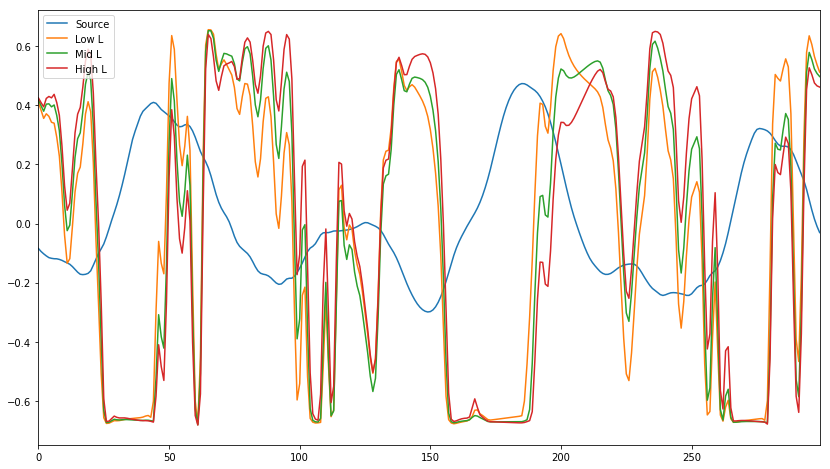

In [61]:
%matplotlib inline

(fig, ax) = plt.subplots(figsize=(14, 8))

start = 6500
n = start + 300

pd.Series(map(lambda x: x[-1][0], X_tr_ll_f[start:n])).plot.line(ax=ax, label='Source')
pd.Series(y_tr_ll_f[start:n]).plot.line(ax=ax, label='Low L')
pd.Series(y_tr_ml_f[start:n]).plot.line(ax=ax, label='Mid L')
pd.Series(y_tr_hl_f[start:n]).plot.line(ax=ax, label='High L')
ax.legend()

In [62]:
from sklearn.metrics import mean_absolute_error as mae

print('mae(l, h)', mae(y_tr_ll_f, y_tr_hl_f))
print('mae(l, m)', mae(y_tr_ll_f, y_tr_ml_f))
print('mae(m, h)', mae(y_tr_ml_f, y_tr_hl_f))

mae(l, h) 0.1262394
mae(l, m) 0.07580748
mae(m, h) 0.059114657


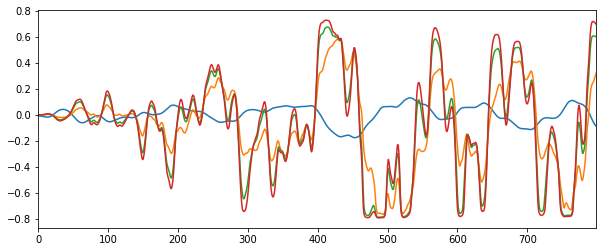

In [187]:
%matplotlib inline

(fig, ax) = plt.subplots(figsize=(10, 4))

pd.Series(map(lambda x: x[-1][0], X_tr_lm_f[:800])).plot.line(ax=ax)
pd.Series(y_tr_lm_f[:800]).plot.line(ax=ax)
pd.Series(y_tr_mm_f[:800]).plot.line(ax=ax)
pd.Series(y_tr_hm_f[:800]).plot.line(ax=ax)

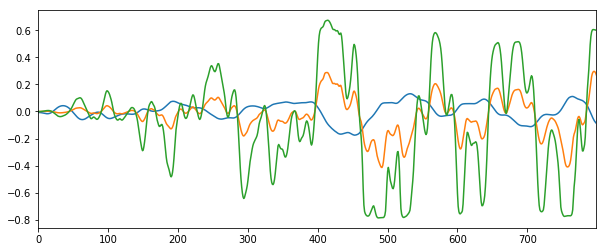

In [172]:
%matplotlib inline

(fig, ax) = plt.subplots(figsize=(10, 4))

pd.Series(map(lambda x: x[-1][0], X_te_hg_hm_f[:800])).plot.line(ax=ax)
pd.Series(y_te_lg_lm_f[:800]).plot.line(ax=ax)
pd.Series(y_te_hg_hg_f[:800]).plot.line(ax=ax)

In [188]:
X_tr_s = np.concatenate([X_tr_lg_f, X_tr_mg_f, X_tr_hg_f, X_tr_lm_f, X_tr_mm_f, X_tr_hm_f])
y_tr_s = np.concatenate([y_tr_lg_f, y_tr_mg_f, y_tr_hg_f, y_tr_lm_f, y_tr_mm_f, y_tr_hm_f])
     
len(X_tr_s), len(y_tr_s), np.min(X_tr_s), np.min(y_tr_s)

(18810, 18810, -0.18082216, -0.79985964)

In [189]:
X_te_s = np.concatenate([X_te_lg_lm_f, X_te_hg_hm_f])
y_te_s = np.concatenate([y_te_lg_lm_f, y_te_hg_hg_f])
     
len(X_te_s), len(y_te_s), np.min(X_te_s), np.min(y_te_s)

(175870, 175870, -0.22959074, -0.7874996)

In [190]:
def add_stats(row):
    stats = [
        np.abs(row[-1]),
        -np.abs(row[-1]),
#         np.mean(row),
#         np.max(row),
#         np.min(row),
#         np.var(row)
    ]

    return np.array([(list(x) + list(stats)) for x in row])

In [191]:
N_REPEAT = 4
N_REPEAT

4

In [192]:
X_tr_s[0][0]

array([3.051851e-05, 1.000000e+00, 5.000000e+00], dtype=float32)

## Finished data processing!

## Moving on to training NN

In [125]:
import numpy as np

In [126]:
# num_steps=100, 24 hidden states

In [127]:
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Reshape, GRU, CuDNNGRU, GaussianNoise
from keras.layers import Convolution2D, MaxPooling2D, Layer, Input, BatchNormalization
from keras.utils import np_utils
from keras.regularizers import L1L2
from keras.layers.merge import concatenate

tf.set_random_seed(1234)

In [128]:
X_tr_s.shape, y_tr_s.shape, X_te_s.shape, y_te_s.shape

((18810, 64, 3), (18810,), (6270, 64, 3), (6270,))

In [129]:
y_tr_s

array([-1.5259255e-04, -1.8311106e-04, -1.5259255e-04, ...,
        3.9228493e-01,  3.8871425e-01,  4.1084018e-01], dtype=float32)

In [130]:
from keras import backend as K
from keras.layers import Layer

class DebugLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(DebugLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DebugLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x[0])
        return x

In [131]:
from scipy.signal import savgol_filter
from matplotlib import pyplot as plt


# TensorBoard callback
# tensorboard_cb = keras.callbacks.TensorBoard(
#     log_dir='./logs',
#     batch_size=BATCH_SIZE,
#     # histogram_freq='batch',
#     write_graph=True,
#     write_grads=True,
#     write_images=True
# )

class TestModel(keras.callbacks.Callback):
    def __init__(self, model, I=200, batch_size=1):
        self.model = model
        self.I = I
        self.batch_size = batch_size
        
    def on_train_begin(self, epoch_n):
        (fig, ax) = plt.subplots(figsize=(12, 8))
        I = self.I
#         (fig, ax) = plt.subplots()
        self.fig = fig
        self.ax = ax
        
        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        feat_data, =  ax.plot(feat.values, label='feature')

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(np.zeros(I))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        zeros = pd.Series(np.zeros(I))
        zeros.plot.line(ax=ax, label='0')

        targ_data, = ax.plot(targ.values, label='target')

        pred_data, = ax.plot(pred.values, label='predicted')
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')
        
        self.feat_data = feat_data
        self.targ_data = targ_data
        self.pred_data = pred_data
        
        ax.legend(loc='upper right')
        ax.set_title('NN predictions on first {} samples'.format(I))
        ax.set_xlabel('index')
        ax.set_ylabel('value')
        
        plt.show()
        fig.canvas.draw()
        
        
    def on_epoch_end(self, epoch_n, logs={}):
        loss = logs['loss']
        model = self.model
        
        fig = self.fig
        ax = self.ax
        
        I = self.I
        batch_size = self.batch_size

        feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_tr_s[:I])))))

        self.feat_data.set_ydata(feat.values)

        targ = (pd.Series((y_tr_s[:I])))

        pred = pd.Series(predict(model, X_tr_s[:I], batch_size=batch_size))
        # pred = (pred * 2.2) + 0.001
        pred = pred + 0.001

        # zeros = pd.Series(np.zeros(I))
        # zeros.plot.line(ax=ax, label='0')

        self.targ_data.set_ydata(targ.values)

        self.pred_data.set_ydata(pred.values)
        # pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

        # pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_tr_f[:I]))))).plot.line(ax=ax, label='feature')

        ax.set_title('NN predictions on first {} samples, epoch {}, loss={:.4f}'.format(I, epoch_n, loss))
        
        fig.canvas.draw()


# Callback to display the target and prediciton
# test_model_cb = keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

In [132]:
from keras import backend as K
    
def load_model(filepath):
    model = keras.models.load_model(filepath)
    
    return model
    
    
    
def create_model(params):
    input_L = Input(
        shape=(N_WINDOW_POINTS, n_features),
        batch_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
    )

    # bn_L = (BatchNormalization()(input_L))

    GRU_L = CuDNNGRU
    
    gru_1_L = GRU_L(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         bias_regularizer=L1L2(l1=0.01, l2=0.01),
#         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         activation='tanh',
#         recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
        return_sequences=True,
    )(input_L)

    gru_2_L = GRU_L(
        params['n_units'],
        input_shape=(N_WINDOW_POINTS, n_features),
        batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         bias_regularizer=L1L2(l1=0.01, l2=0.01),
#         recurrent_regularizer=L1L2(l1=0.01, l2=0.01),
        stateful=True,
        # reset_after=True,
        # batch_input_shape=(params['batch_size'], N_WINDOW_POINTS, n_features),
#         activation='tanh',
#         recurrent_activation='hard_sigmoid',
        # kernel_initializer=keras.initializers.RandomNormal(stddev=0.1),
        kernel_initializer=keras.initializers.glorot_uniform(seed=43),
#         recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=42),
        recurrent_initializer=keras.initializers.glorot_uniform(seed=43),
        # kernel_initializer='identity',
        bias_initializer='zeros',
    #     return_sequences=True,
    )(gru_1_L)

    dense_2_l = Dense(
        1,
        activation=None,
        kernel_initializer='identity',
        bias_initializer='zeros',
    # )(gru_1_l)
    )(gru_2_L)


    model = Model(inputs=input_L, outputs=dense_2_l)
    
    return model

    

def train_model(model, X_tr, y_tr, x_val, y_val, params, verbose_fit=0):
    print(params)
    
    optimizer = keras.optimizers.adam(lr=params['lr'], clipvalue=10, clipnorm=10)
    # optimizer = keras.optimizers.SGD(lr=params['lr'], decay=0.2)


    def mean_squared_error(y_true, y_pred):
        return K.mean(K.square(10 * (y_pred - y_true)), axis=-1)

    # model.compile(optimizer=optimizer, loss='mse')
    model.compile(optimizer=optimizer, loss='mae')
    
    # TRAIN

    es_cb = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0005,
        patience=8,
        verbose=0,
        mode='auto',
    )

    def step_decay(epoch):
        initial_lrate = params['lr']
        drop = 0.8
        epochs_drop = 40.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

    lrate = keras.callbacks.LearningRateScheduler(step_decay)

    test_model_cb = TestModel(model, I=min(params['n_samples'], 2000), batch_size=params['batch_size'])

    history = model.fit(
        X_tr_s[:params['n_samples']],
        y_tr_s[:params['n_samples']],
#         X_tr_s[:40],
#         y_tr_s[:40],
        batch_size=params['batch_size'],
        shuffle=False,
    #     epochs=400,
#         epochs=100,
        epochs=params['epochs'],
        verbose=verbose_fit,
#         validation_data=(X_te_s[:1000], y_te_s[:1000]),
        # validation_data=(X_te_s[:200], y_te_s[:200]),
        # callbacks=[es_cb, test_model_cb, tensorboard_cb],
        callbacks=[es_cb, test_model_cb, lrate],
    )
    
    return (history, model)


def create_and_train_model(X_tr, y_tr, x_val, y_val, params):
    model = create_model(params)

    (history, model) = train_model(
        model,
        X_tr_s,
        y_tr_s,
        X_te_s,
        y_te_s,
#         X_tr_s[:params['n_samples']],
#         y_tr_s[:params['n_samples']],
#         X_te_s[:params['n_samples']],
#         y_te_s[:params['n_samples']],
        params
    )
    
    return (history, model)

In [133]:
import math

def predict(model, X_input, batch_size=1, verbose=0):
    # X_input = np.array(rows).reshape(rows.shape[0], rows.shape[1], n_features)
    
    return np.array(
        model.predict(
            X_input[:(math.floor(len(X_input) / batch_size) * batch_size)],
            batch_size=batch_size,
            verbose=verbose,
        )
    ).flatten()


  0%|          | 0/9 [00:00<?, ?it/s]

{'batch_size': 100, 'epochs': 100, 'lr': 0.001, 'n_samples': 4700, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


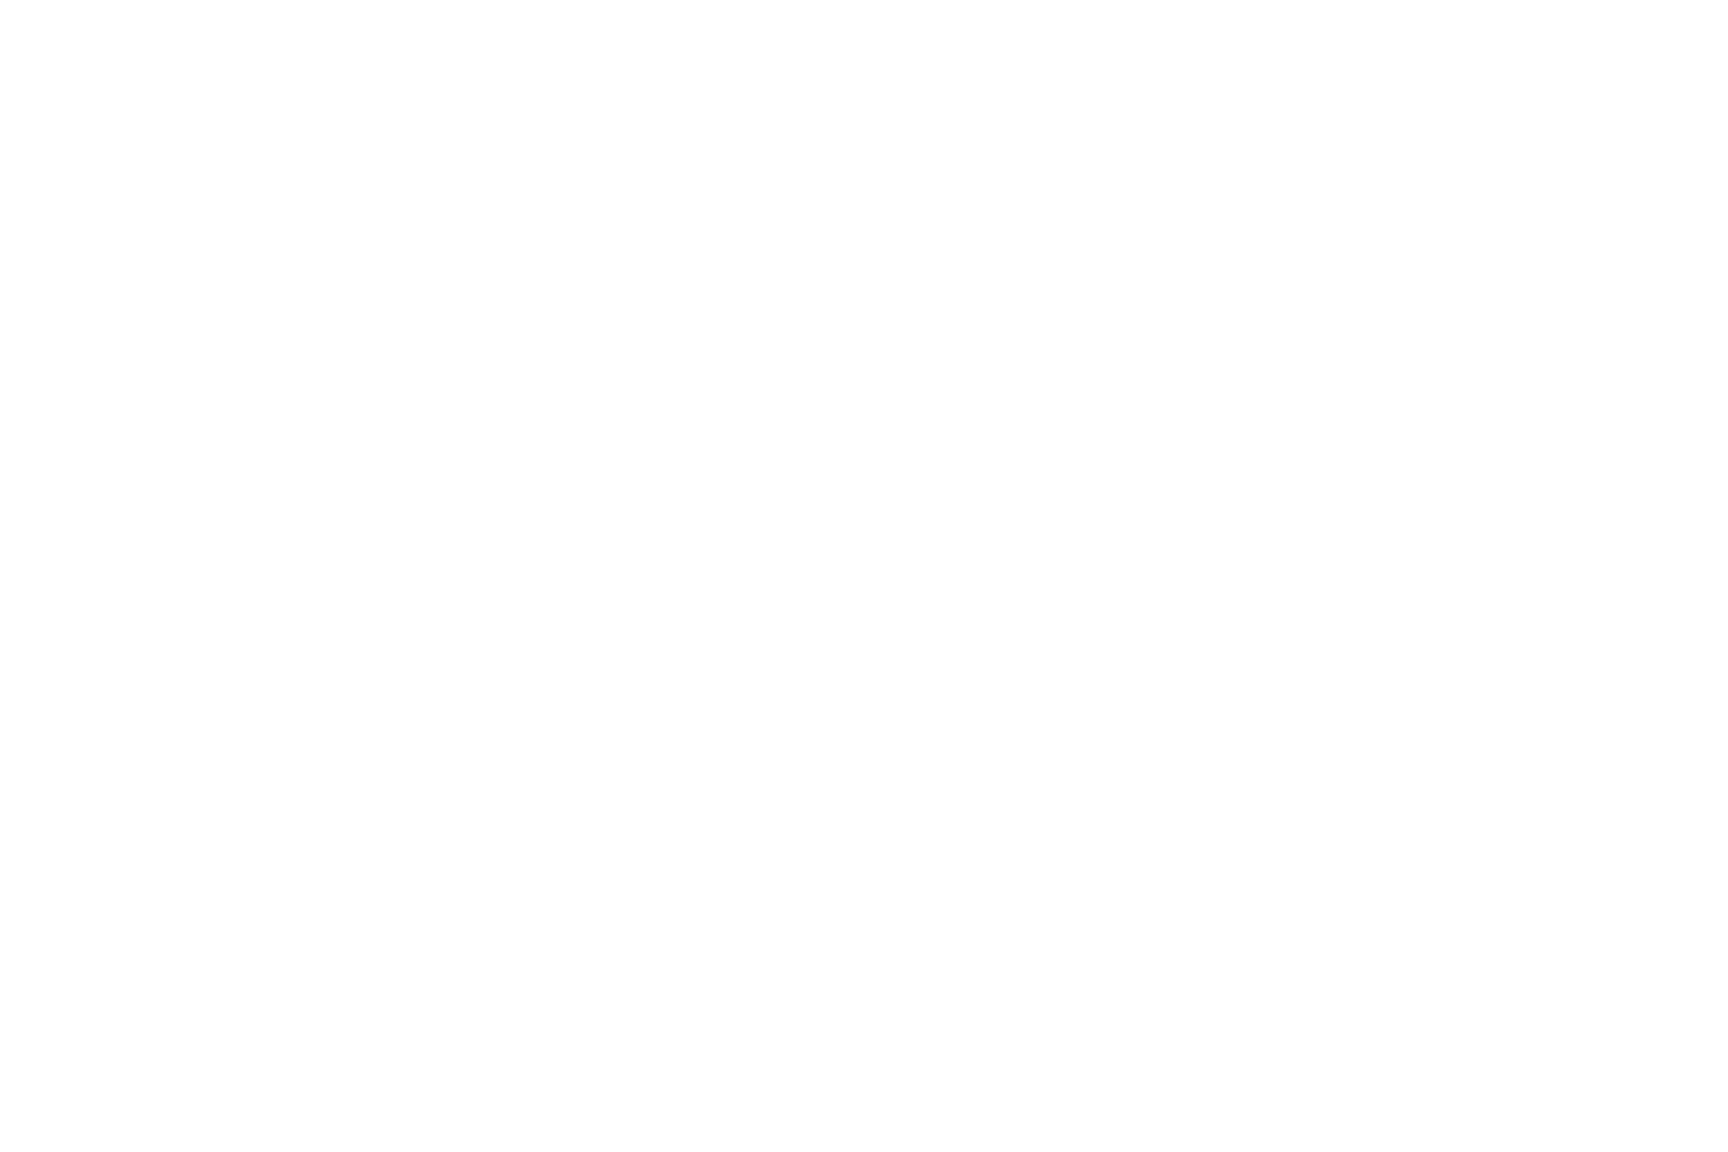


 11%|█         | 1/9 [00:53<07:10, 53.79s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.001, 'n_samples': 4700, 'n_units': 20, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


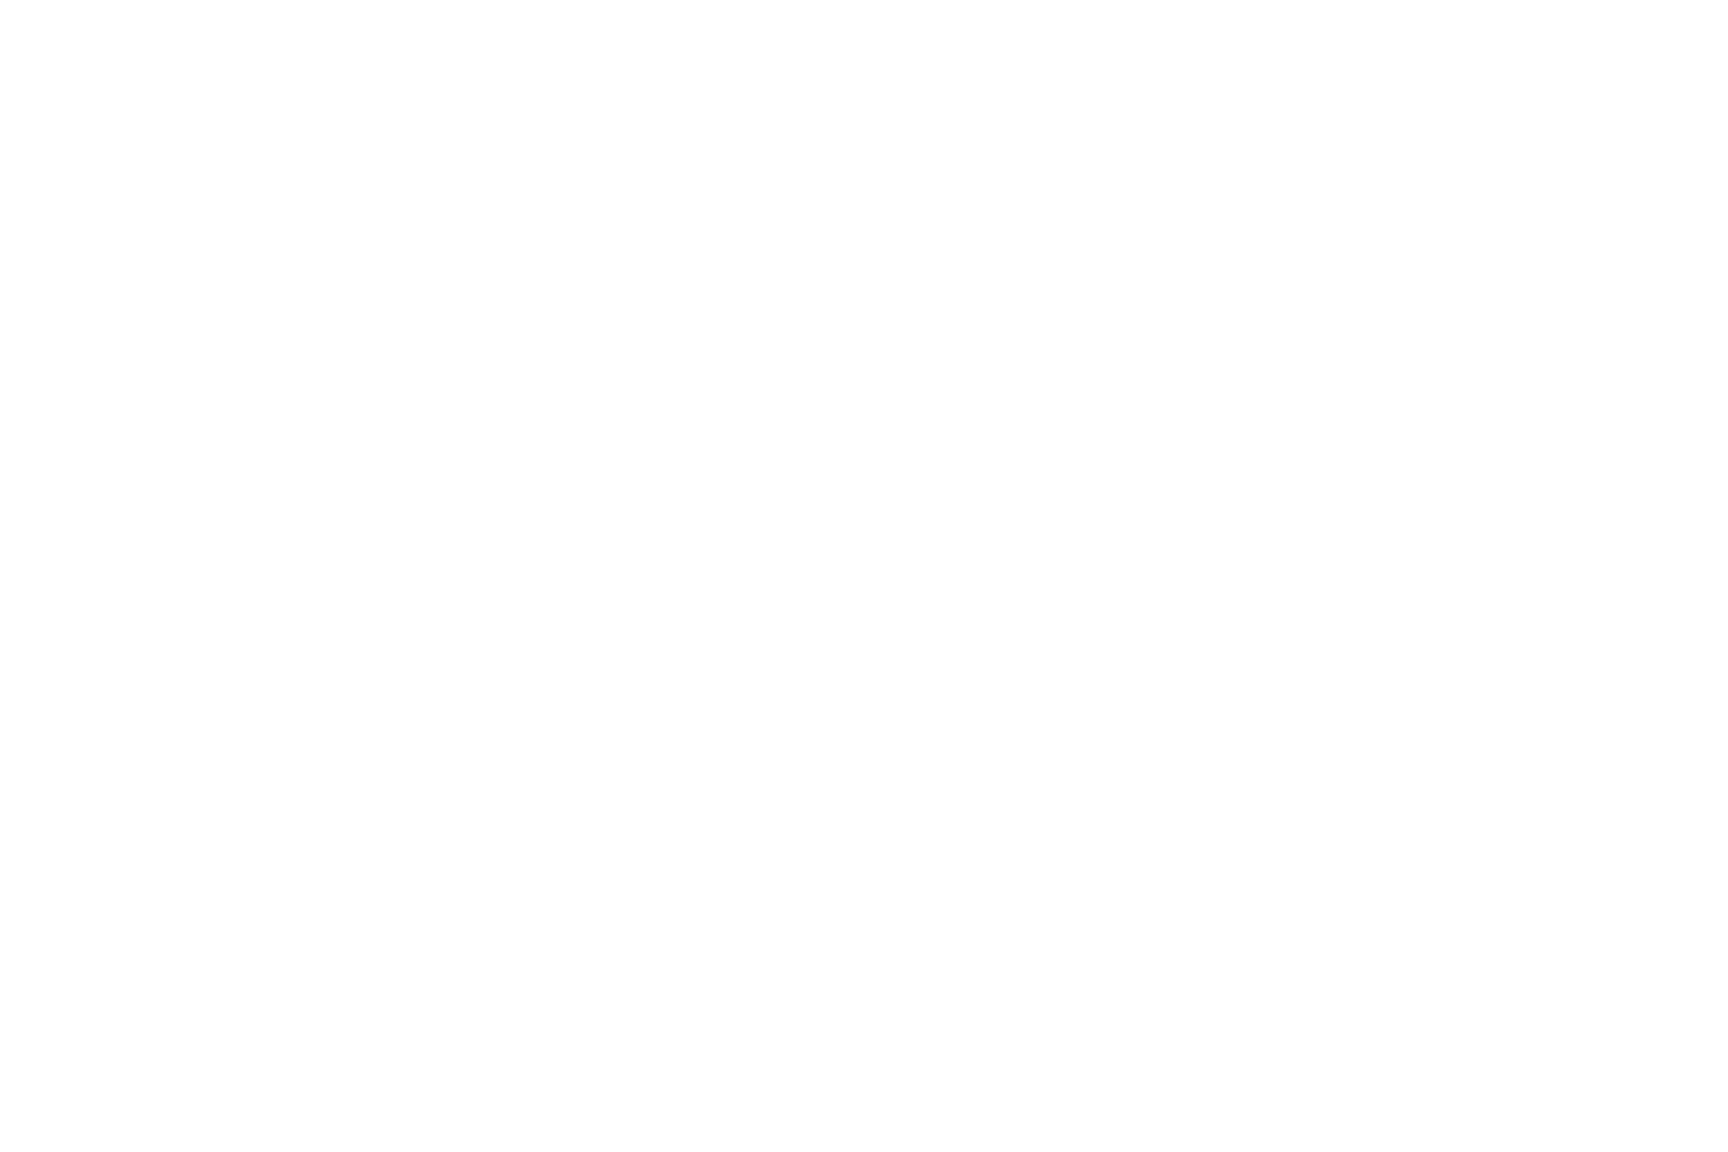


 22%|██▏       | 2/9 [01:48<06:18, 54.10s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.001, 'n_samples': 4700, 'n_units': 24, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


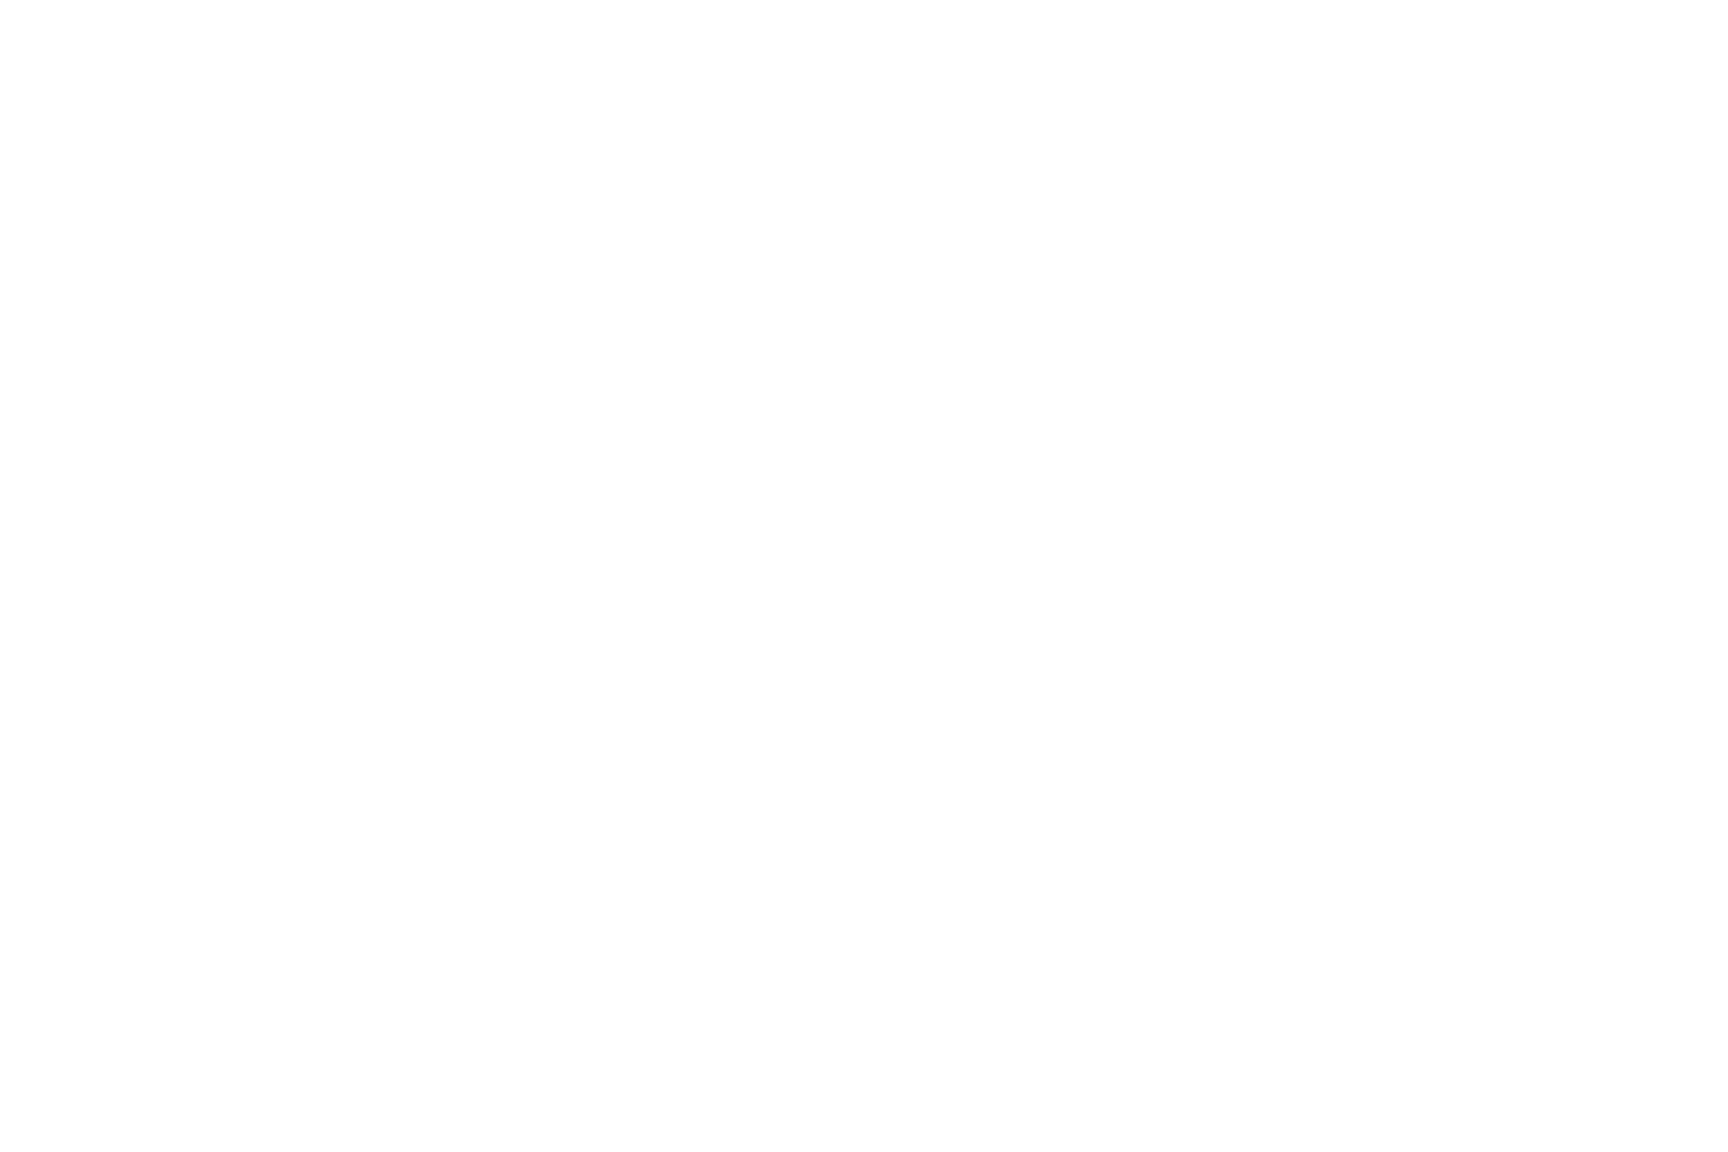


 33%|███▎      | 3/9 [02:43<05:25, 54.22s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.002, 'n_samples': 4700, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


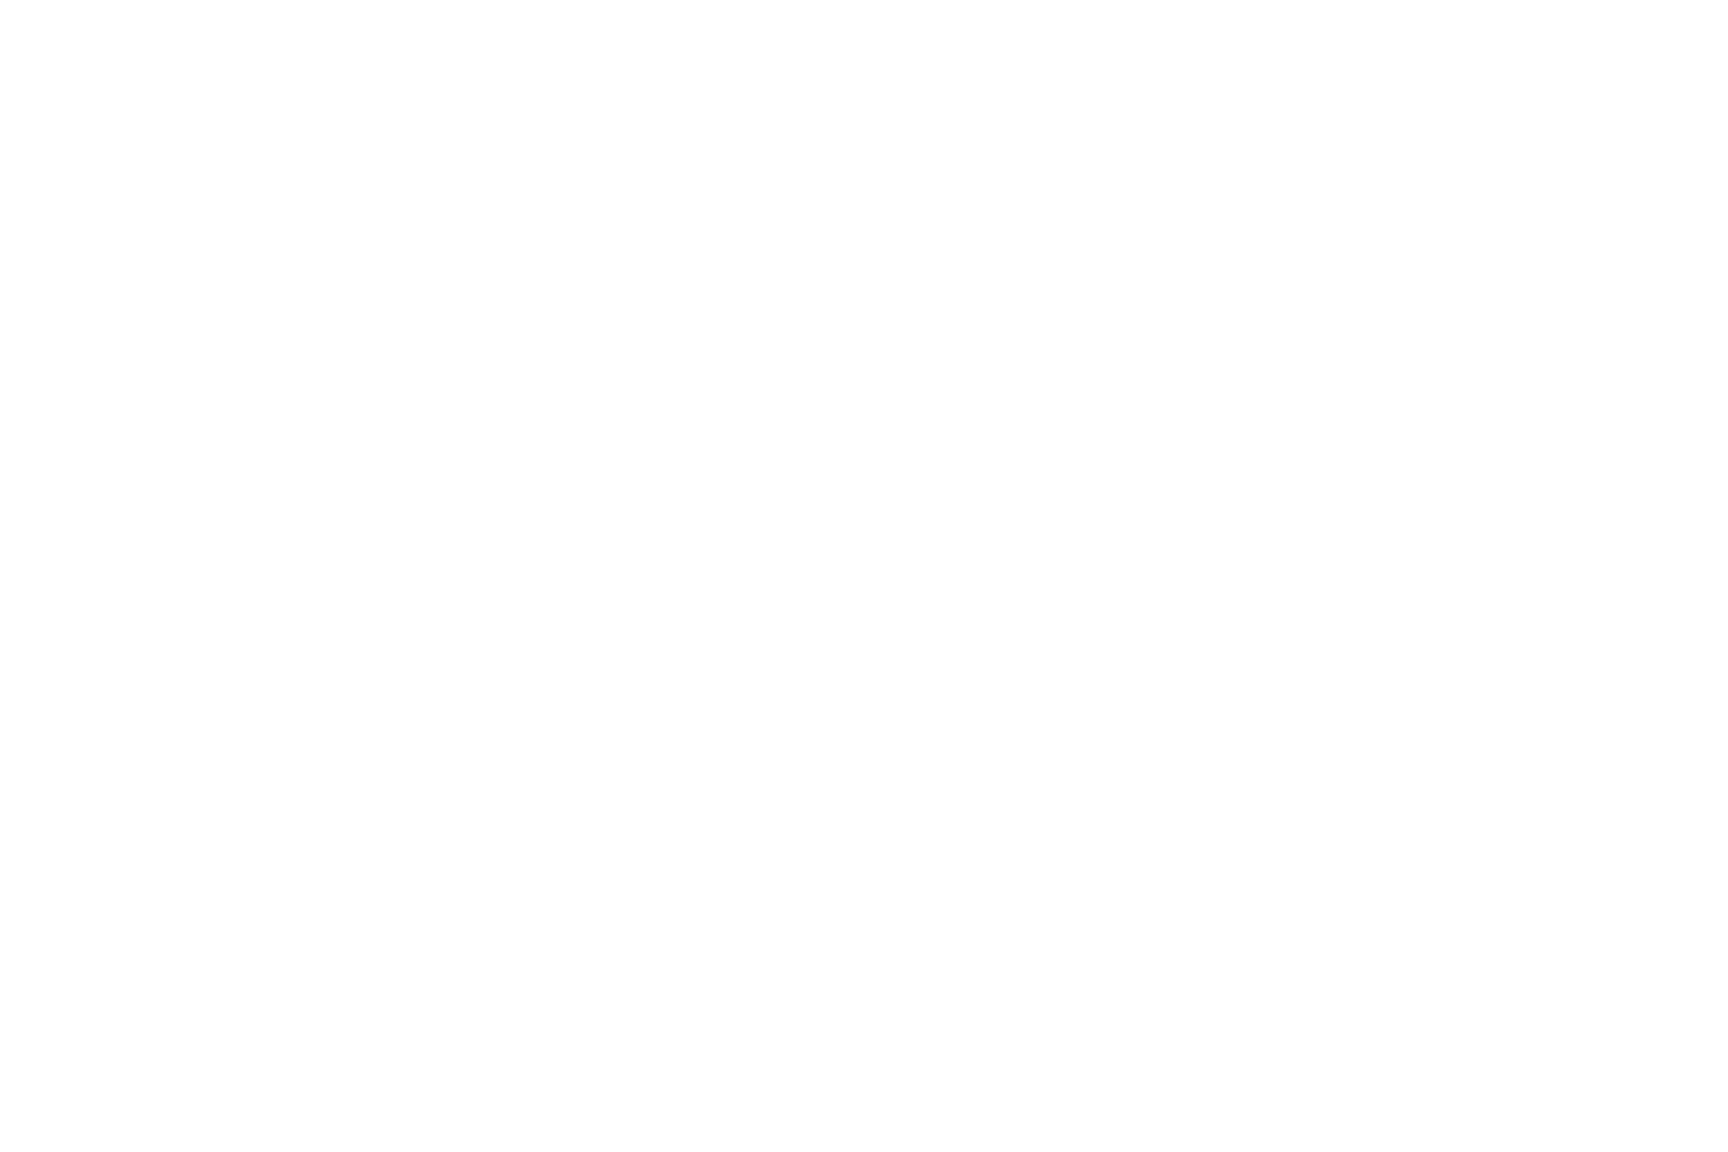


 44%|████▍     | 4/9 [03:36<04:29, 53.98s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.002, 'n_samples': 4700, 'n_units': 20, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


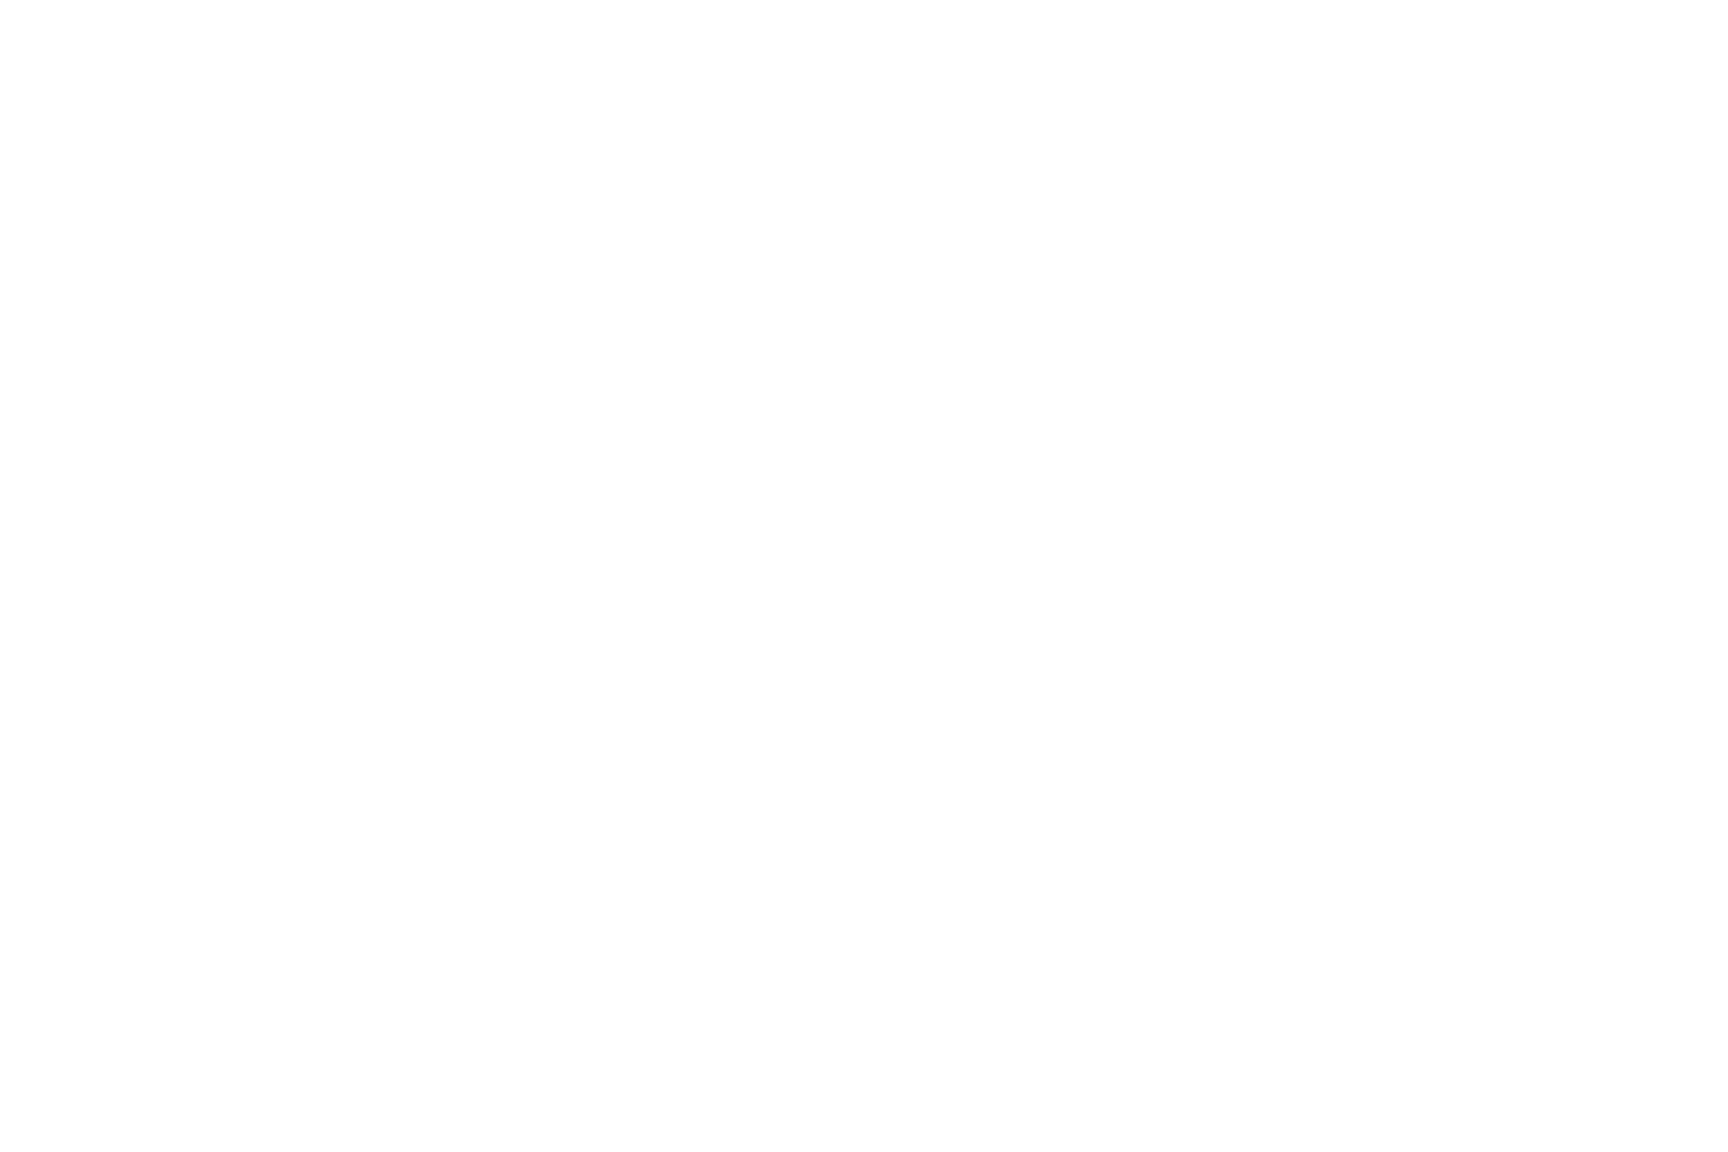


 56%|█████▌    | 5/9 [04:31<03:37, 54.28s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.002, 'n_samples': 4700, 'n_units': 24, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


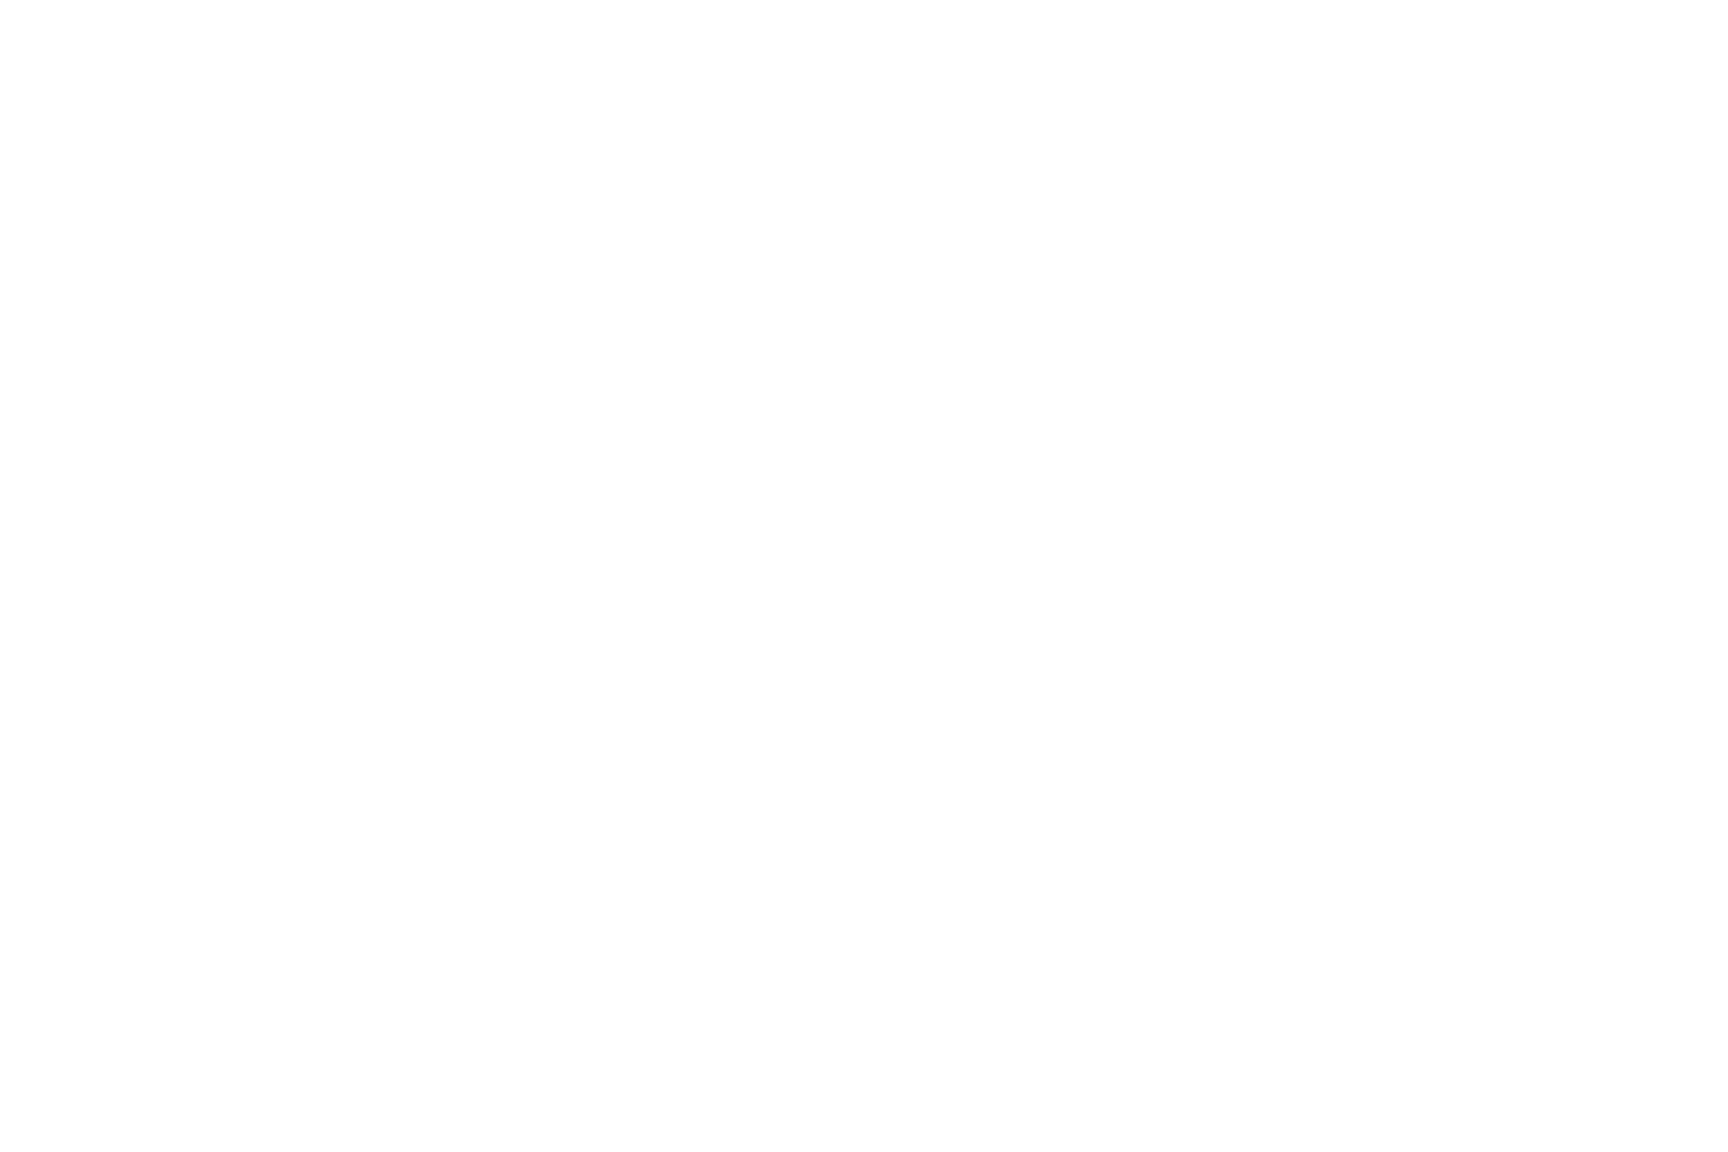


 67%|██████▋   | 6/9 [05:25<02:43, 54.34s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.004, 'n_samples': 4700, 'n_units': 16, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


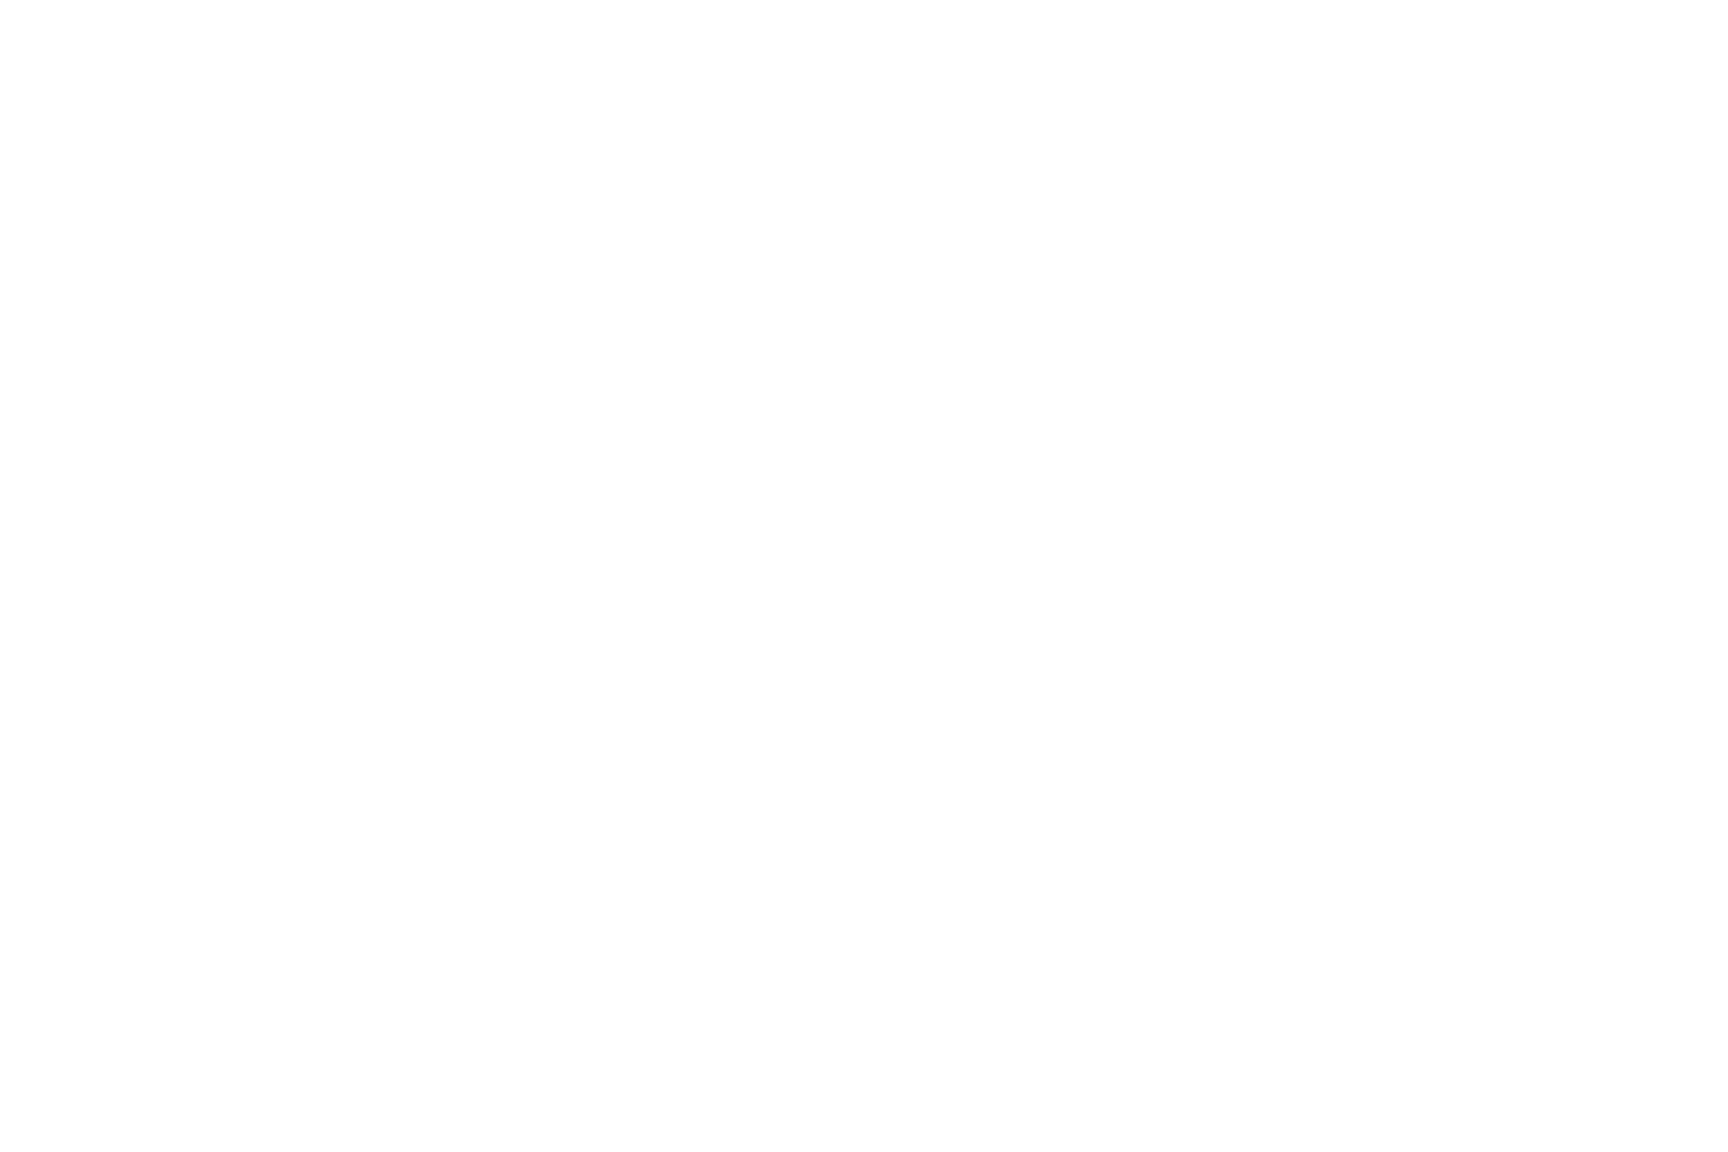


 78%|███████▊  | 7/9 [06:19<01:48, 54.06s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.004, 'n_samples': 4700, 'n_units': 20, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


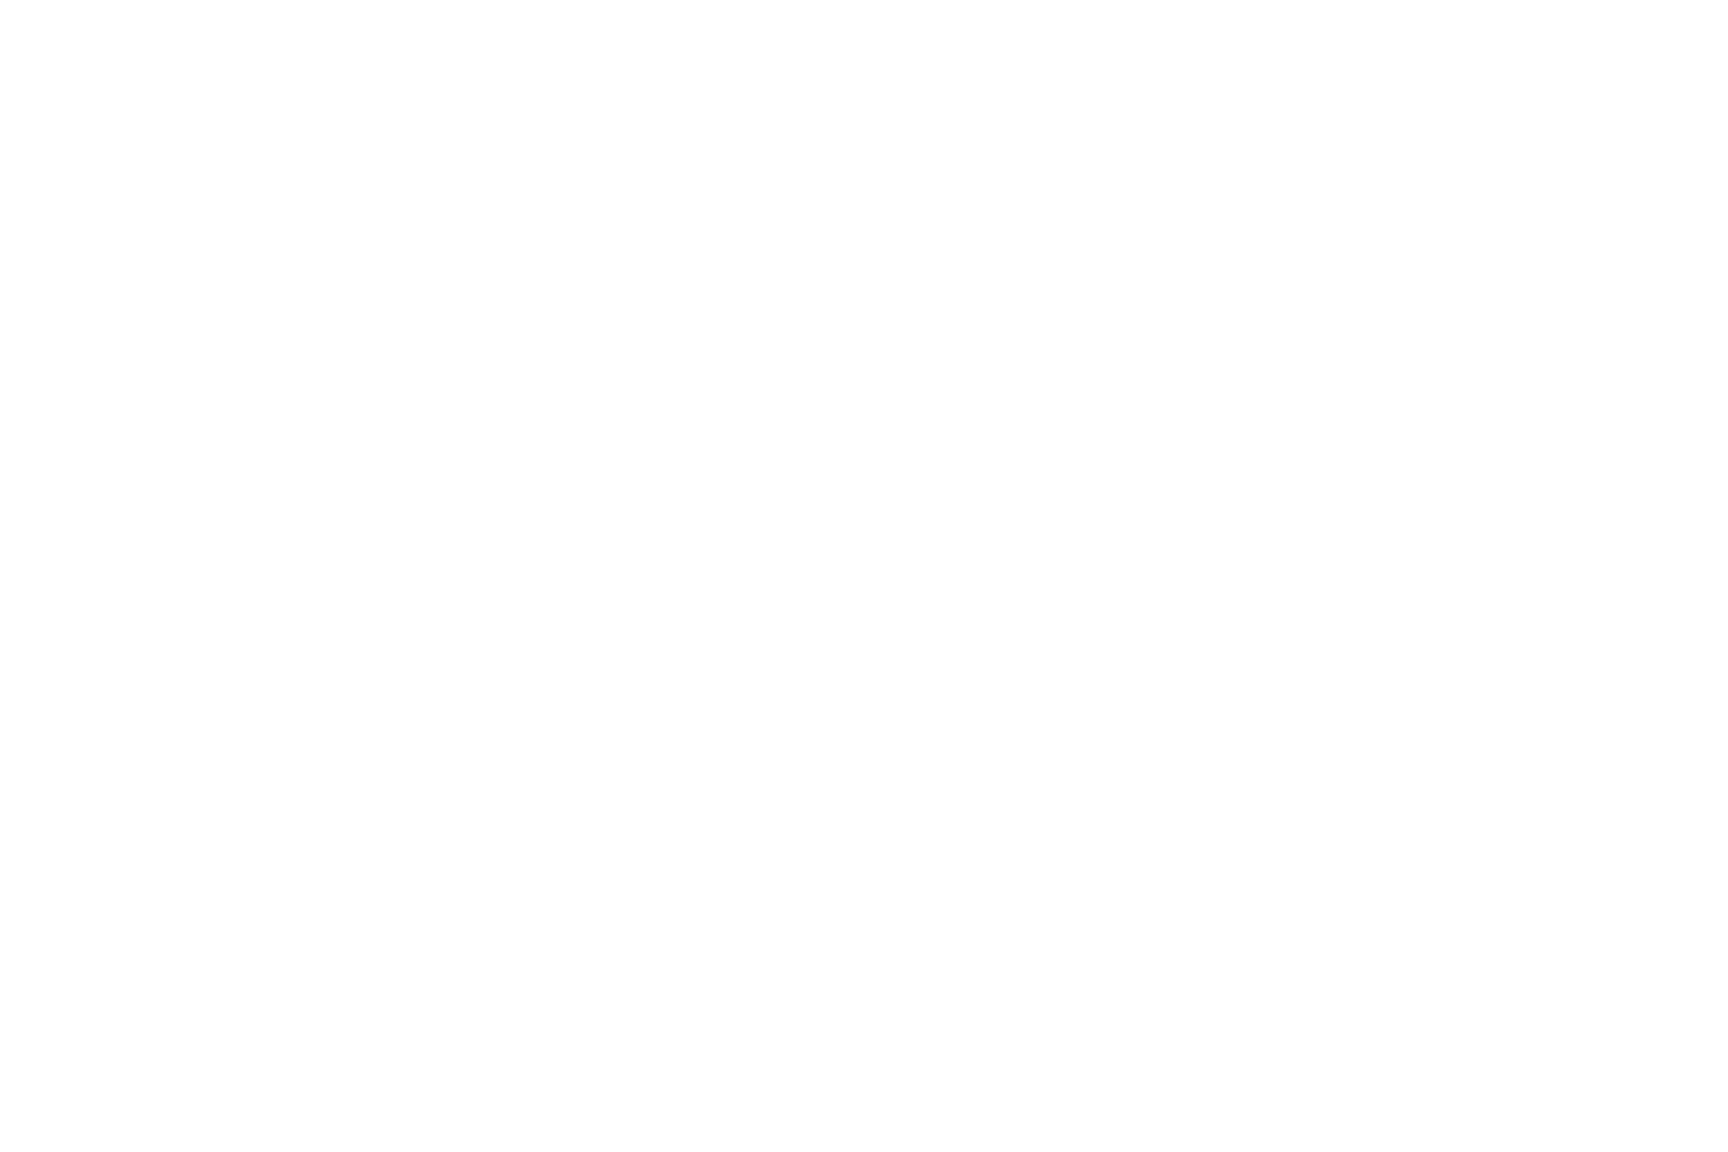


 89%|████████▉ | 8/9 [07:14<00:54, 54.25s/it]

{'batch_size': 100, 'epochs': 100, 'lr': 0.004, 'n_samples': 4700, 'n_units': 24, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


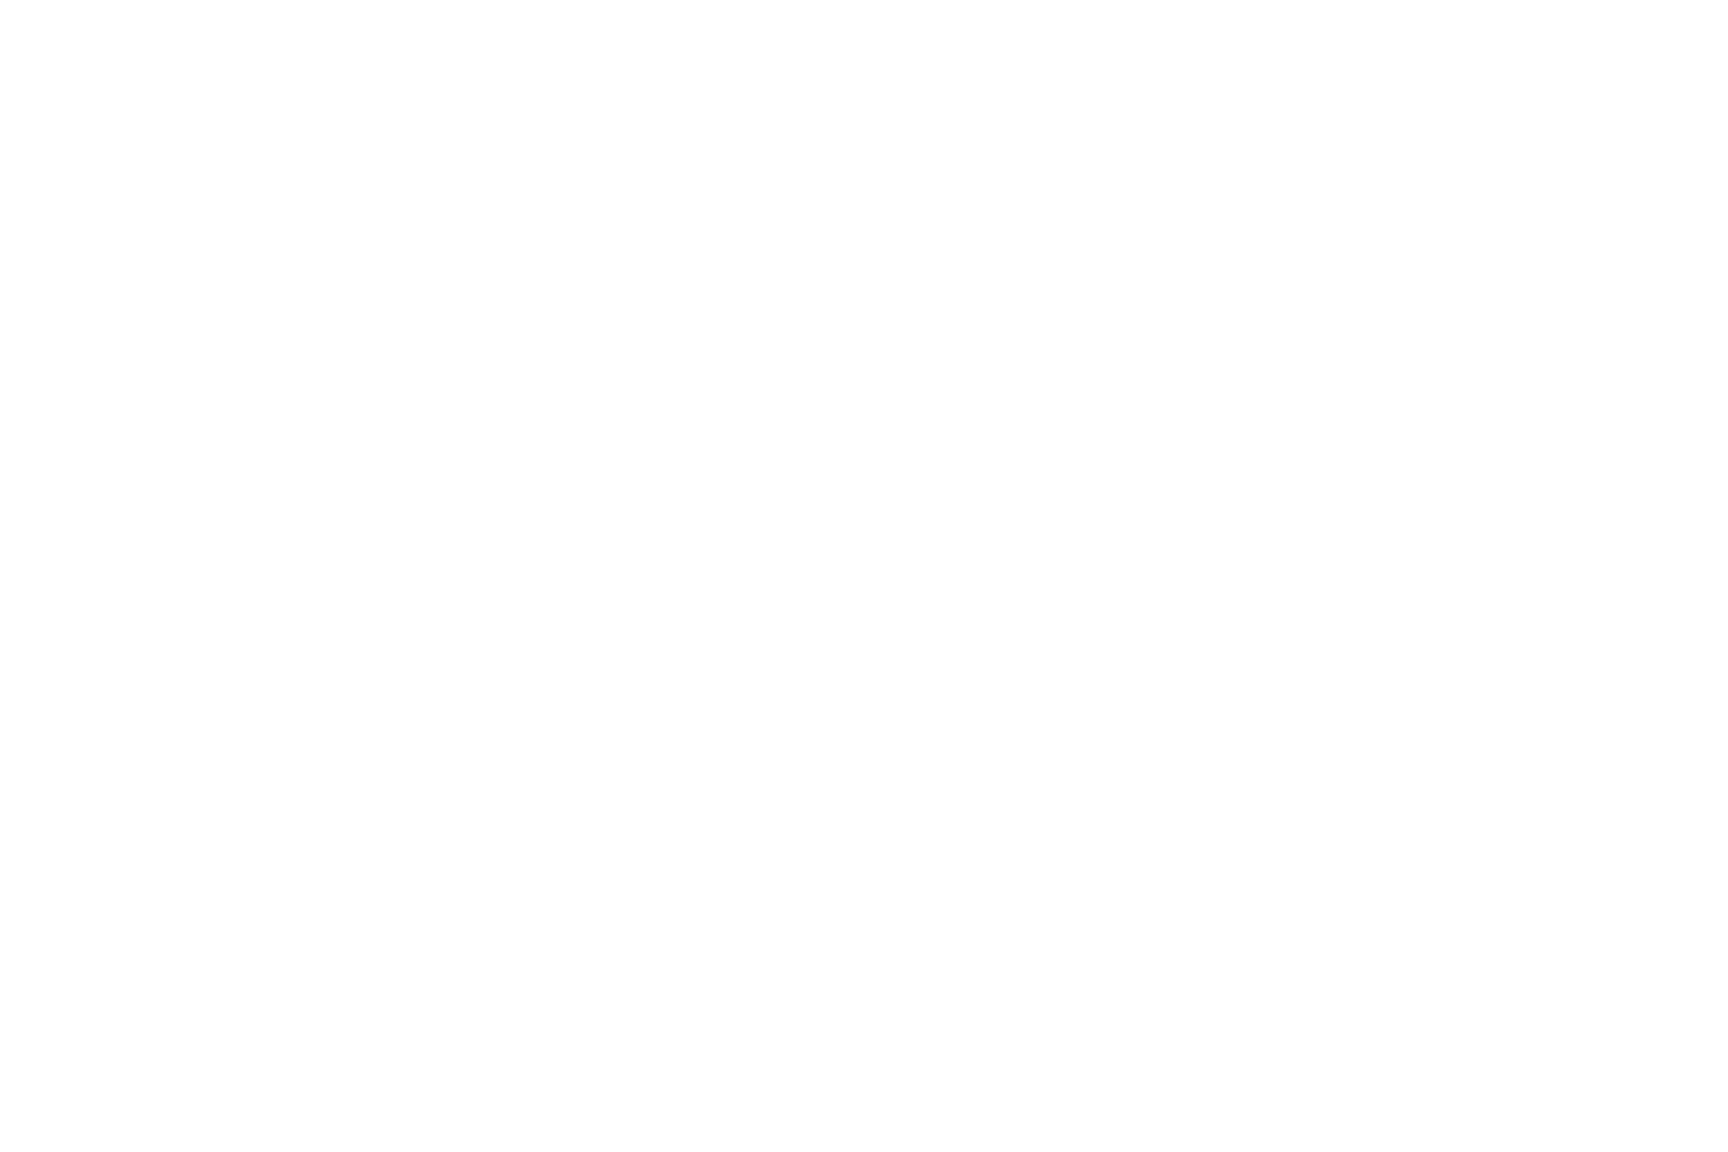


100%|██████████| 9/9 [08:08<00:00, 54.44s/it]

<IPython.core.display.Javascript object>


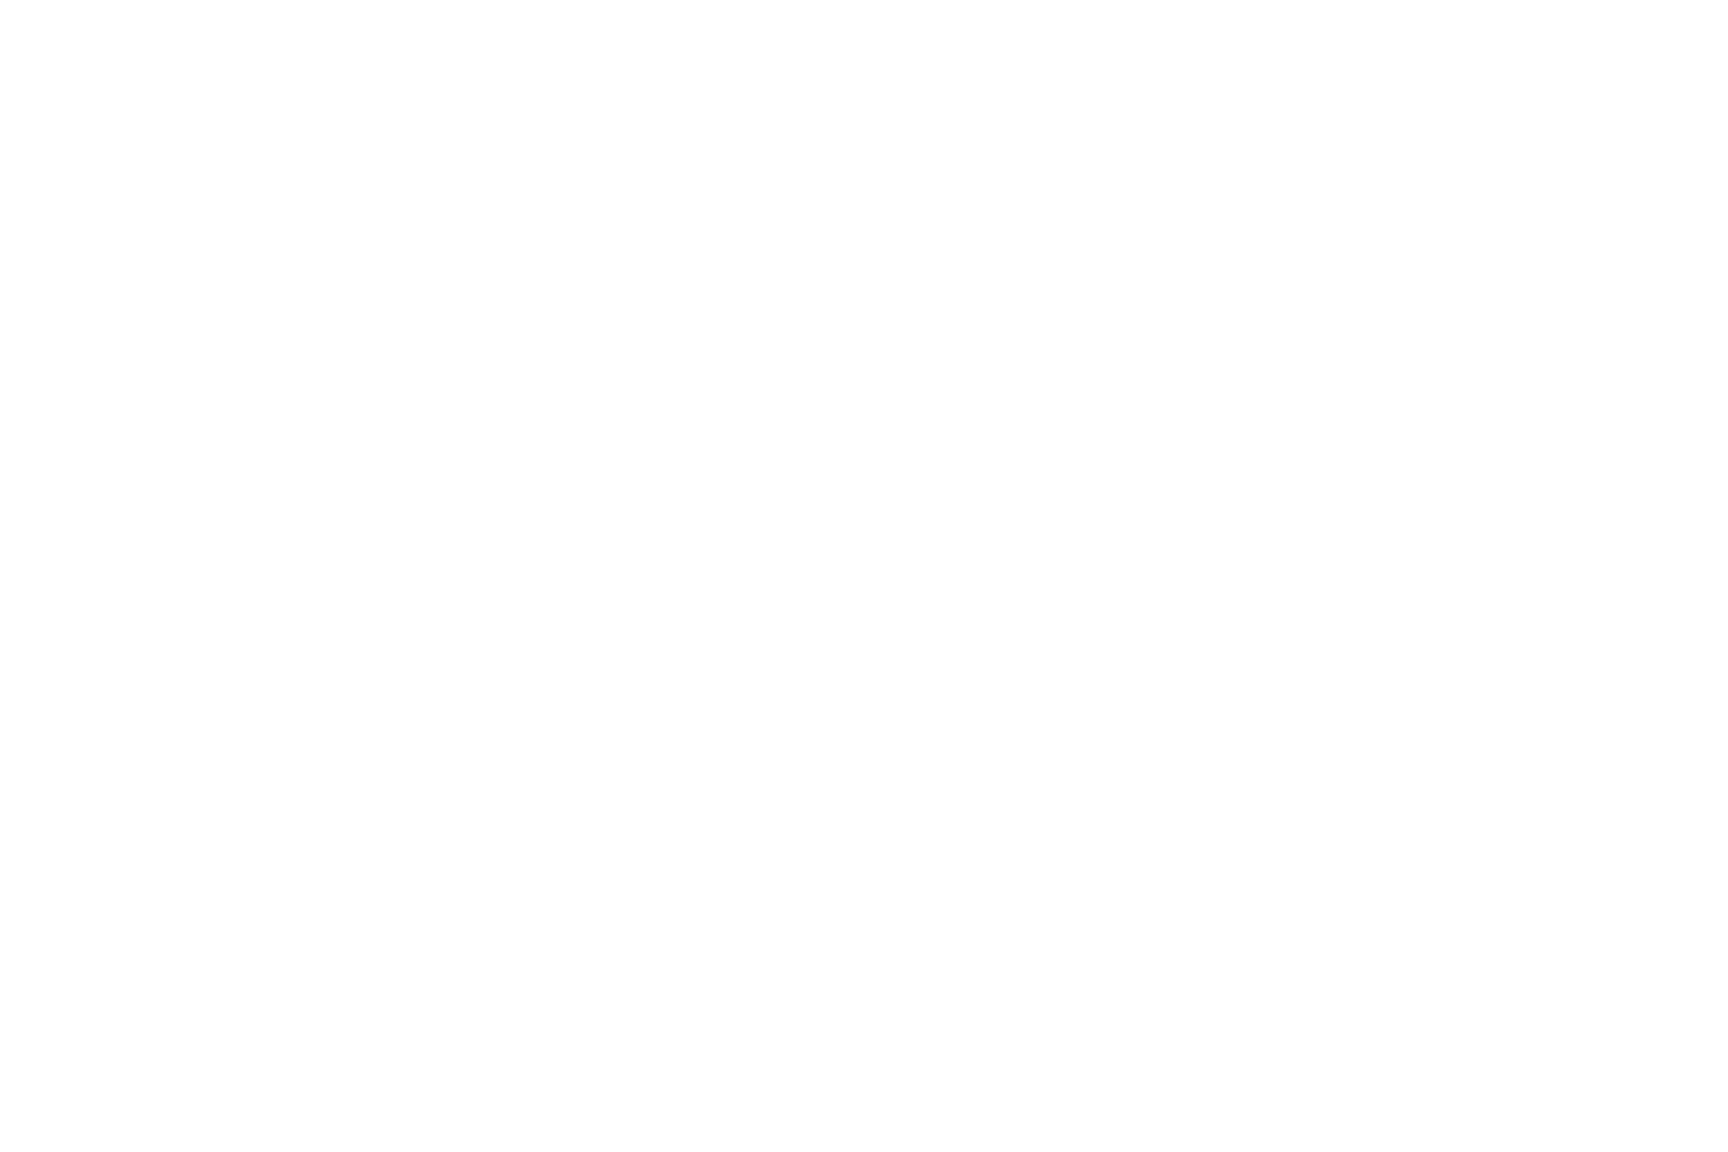

<IPython.core.display.Javascript object>


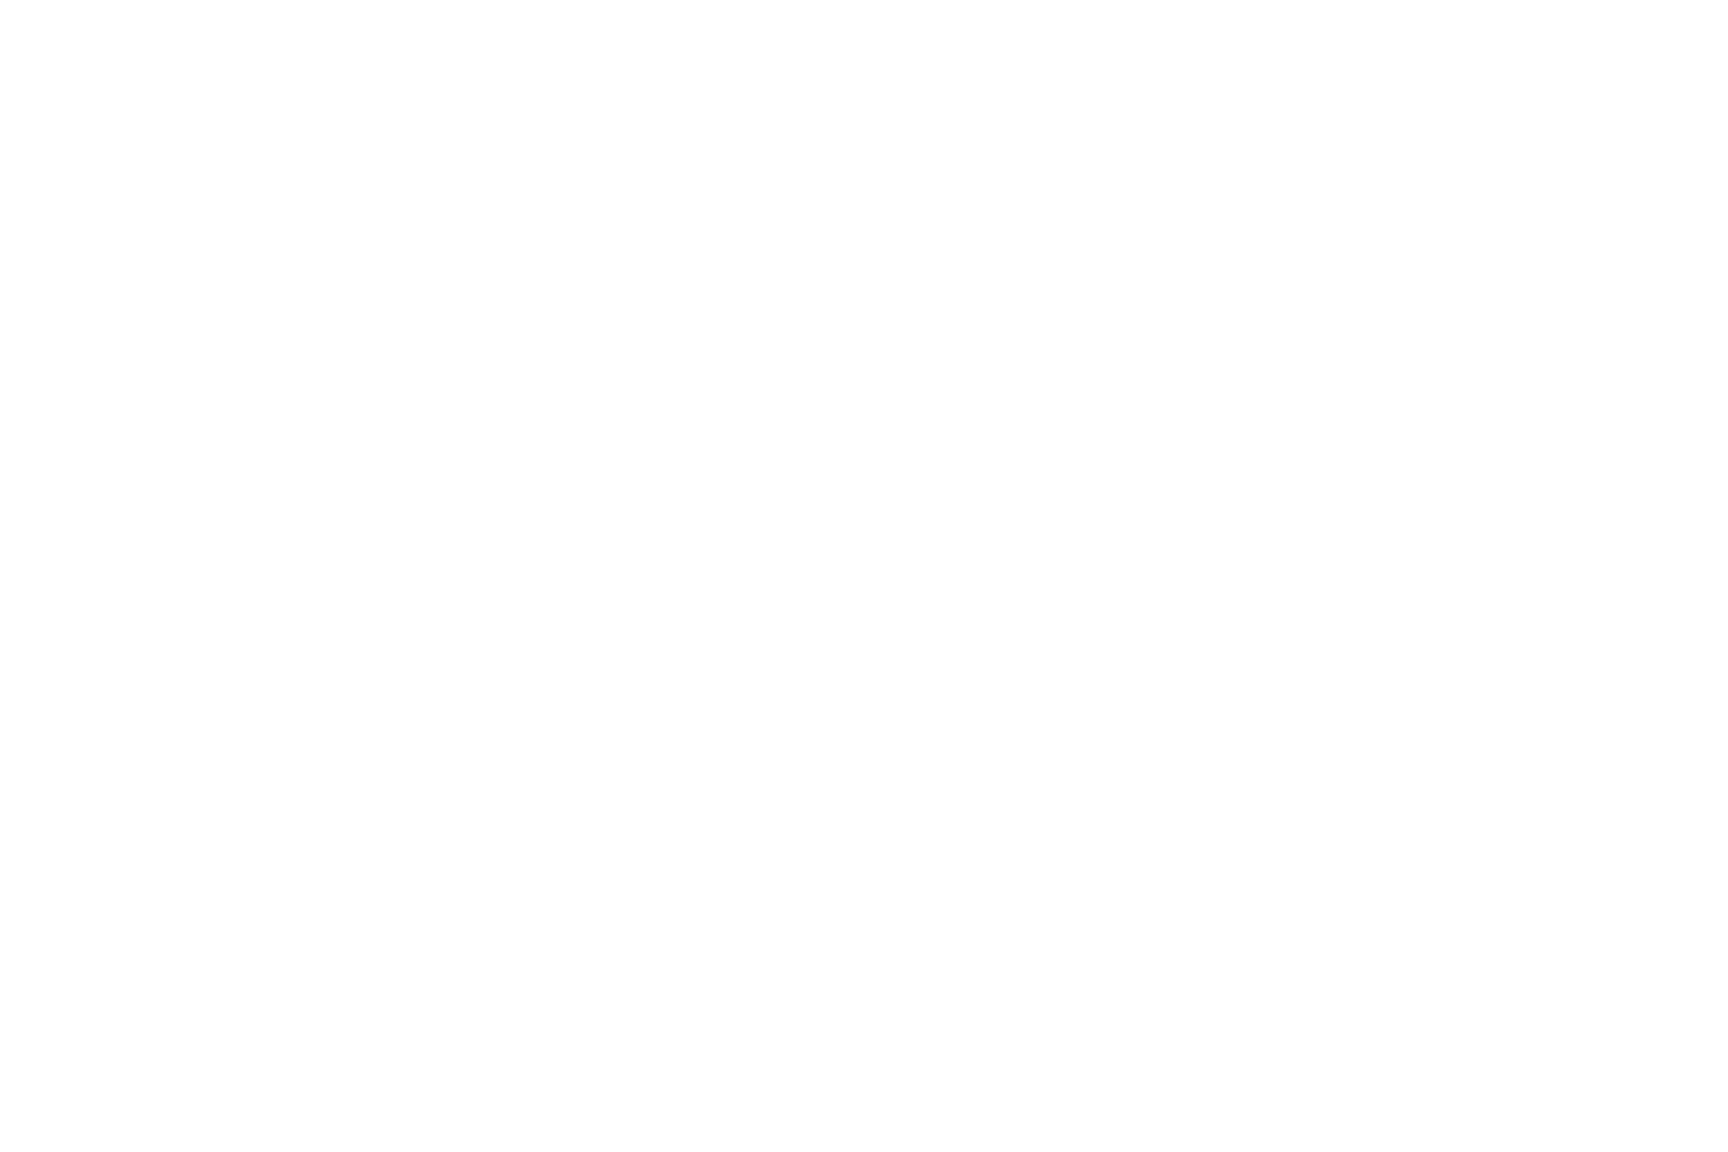

<IPython.core.display.Javascript object>


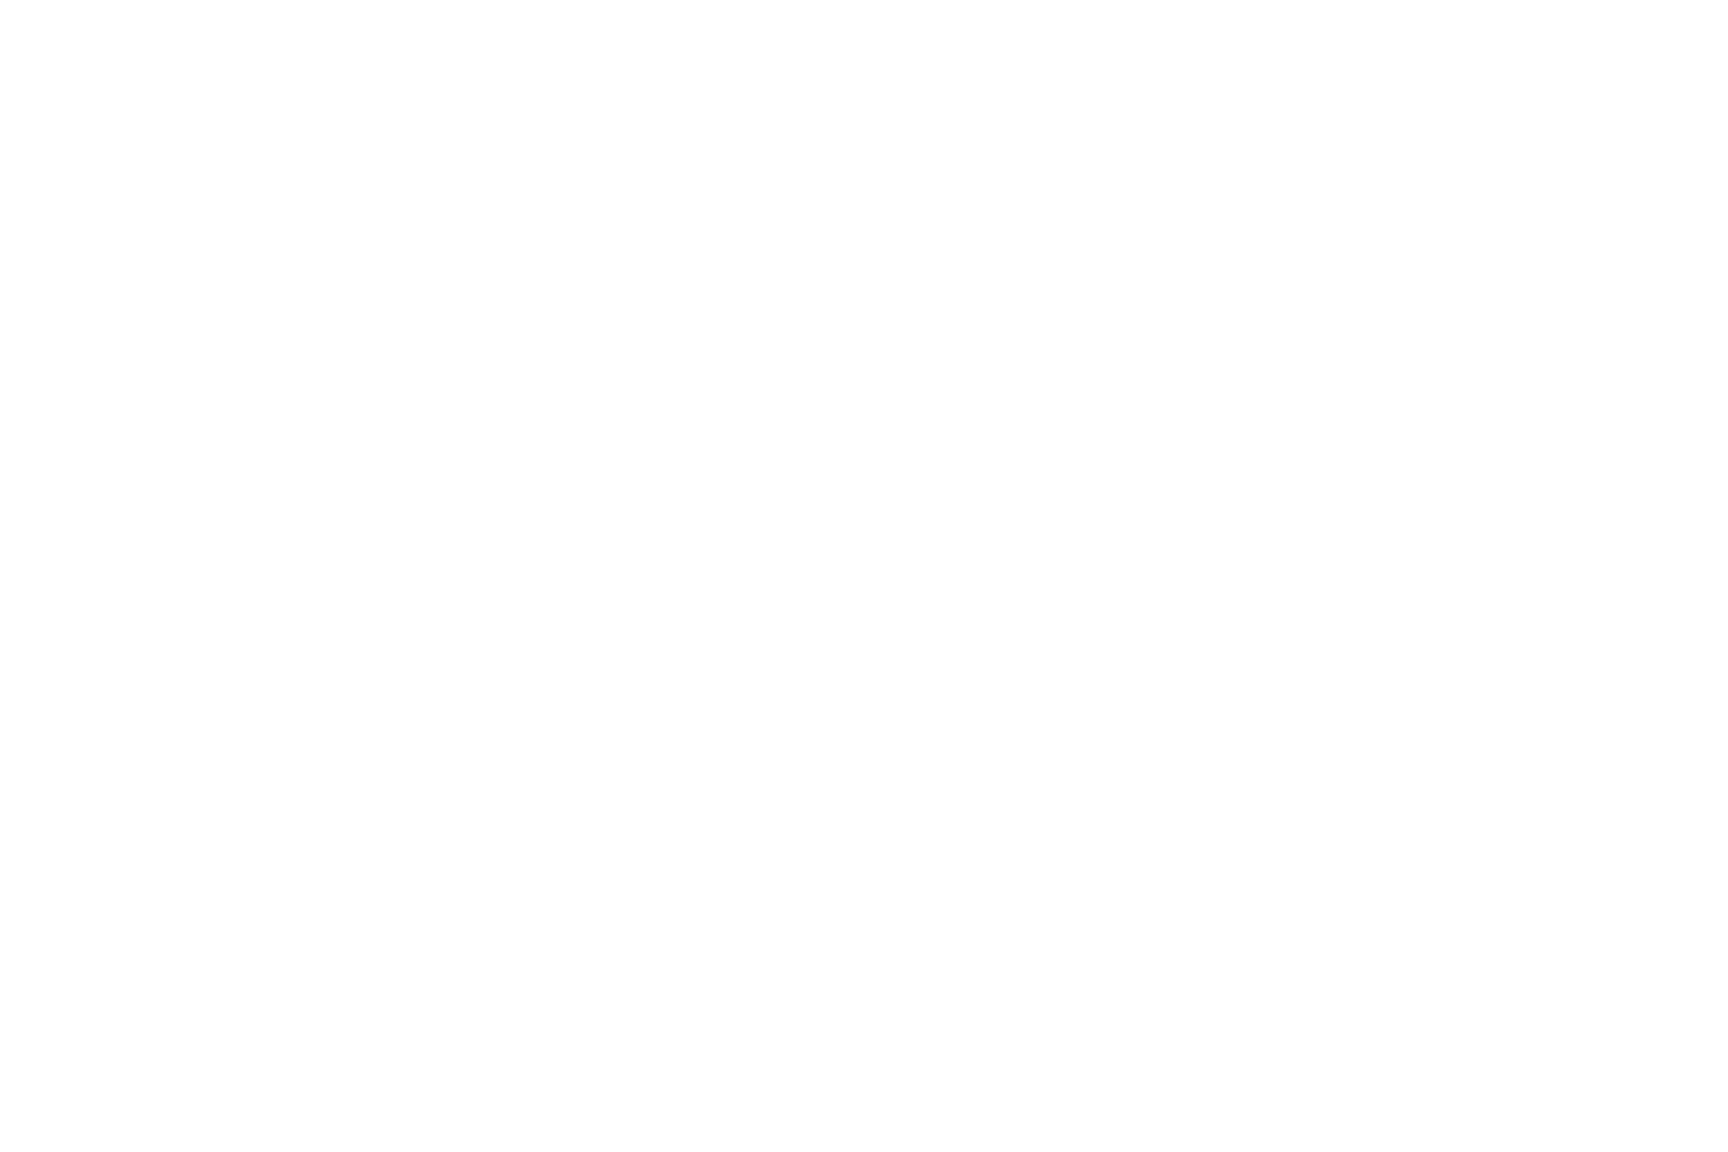

<IPython.core.display.Javascript object>


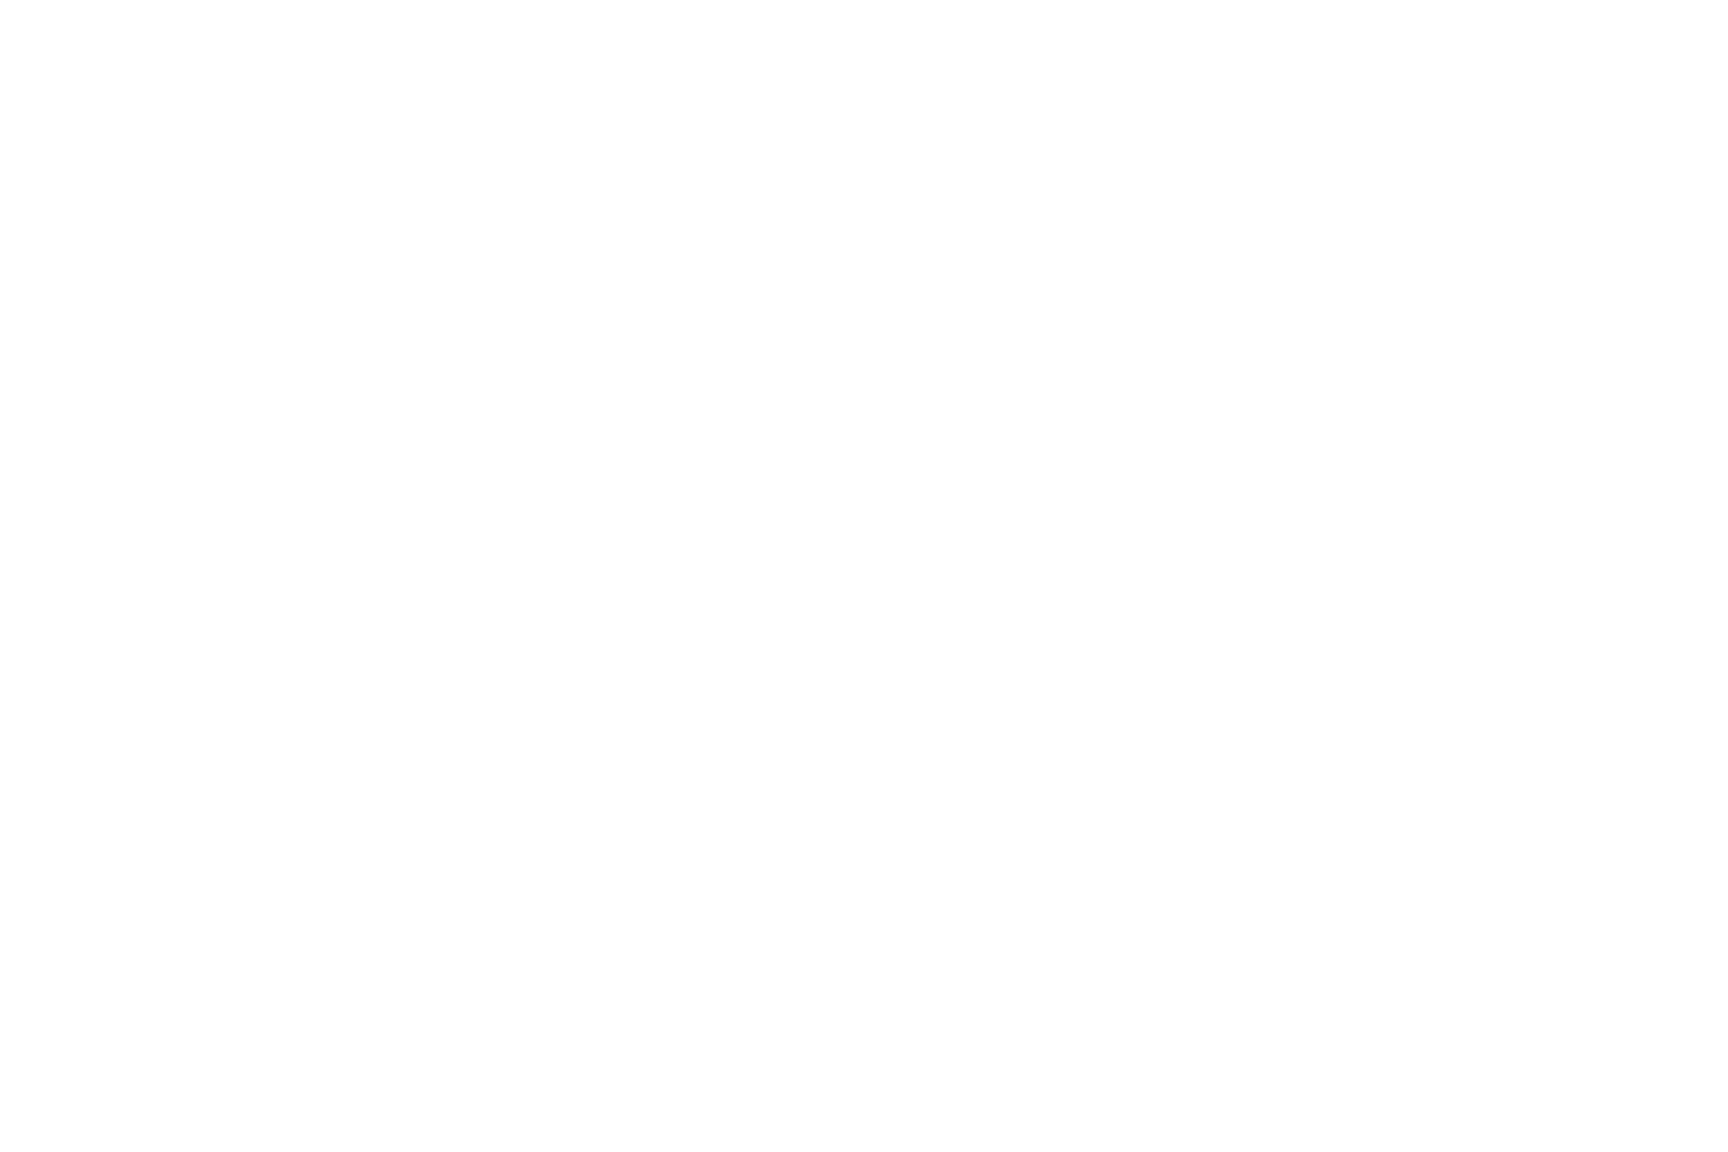

<IPython.core.display.Javascript object>


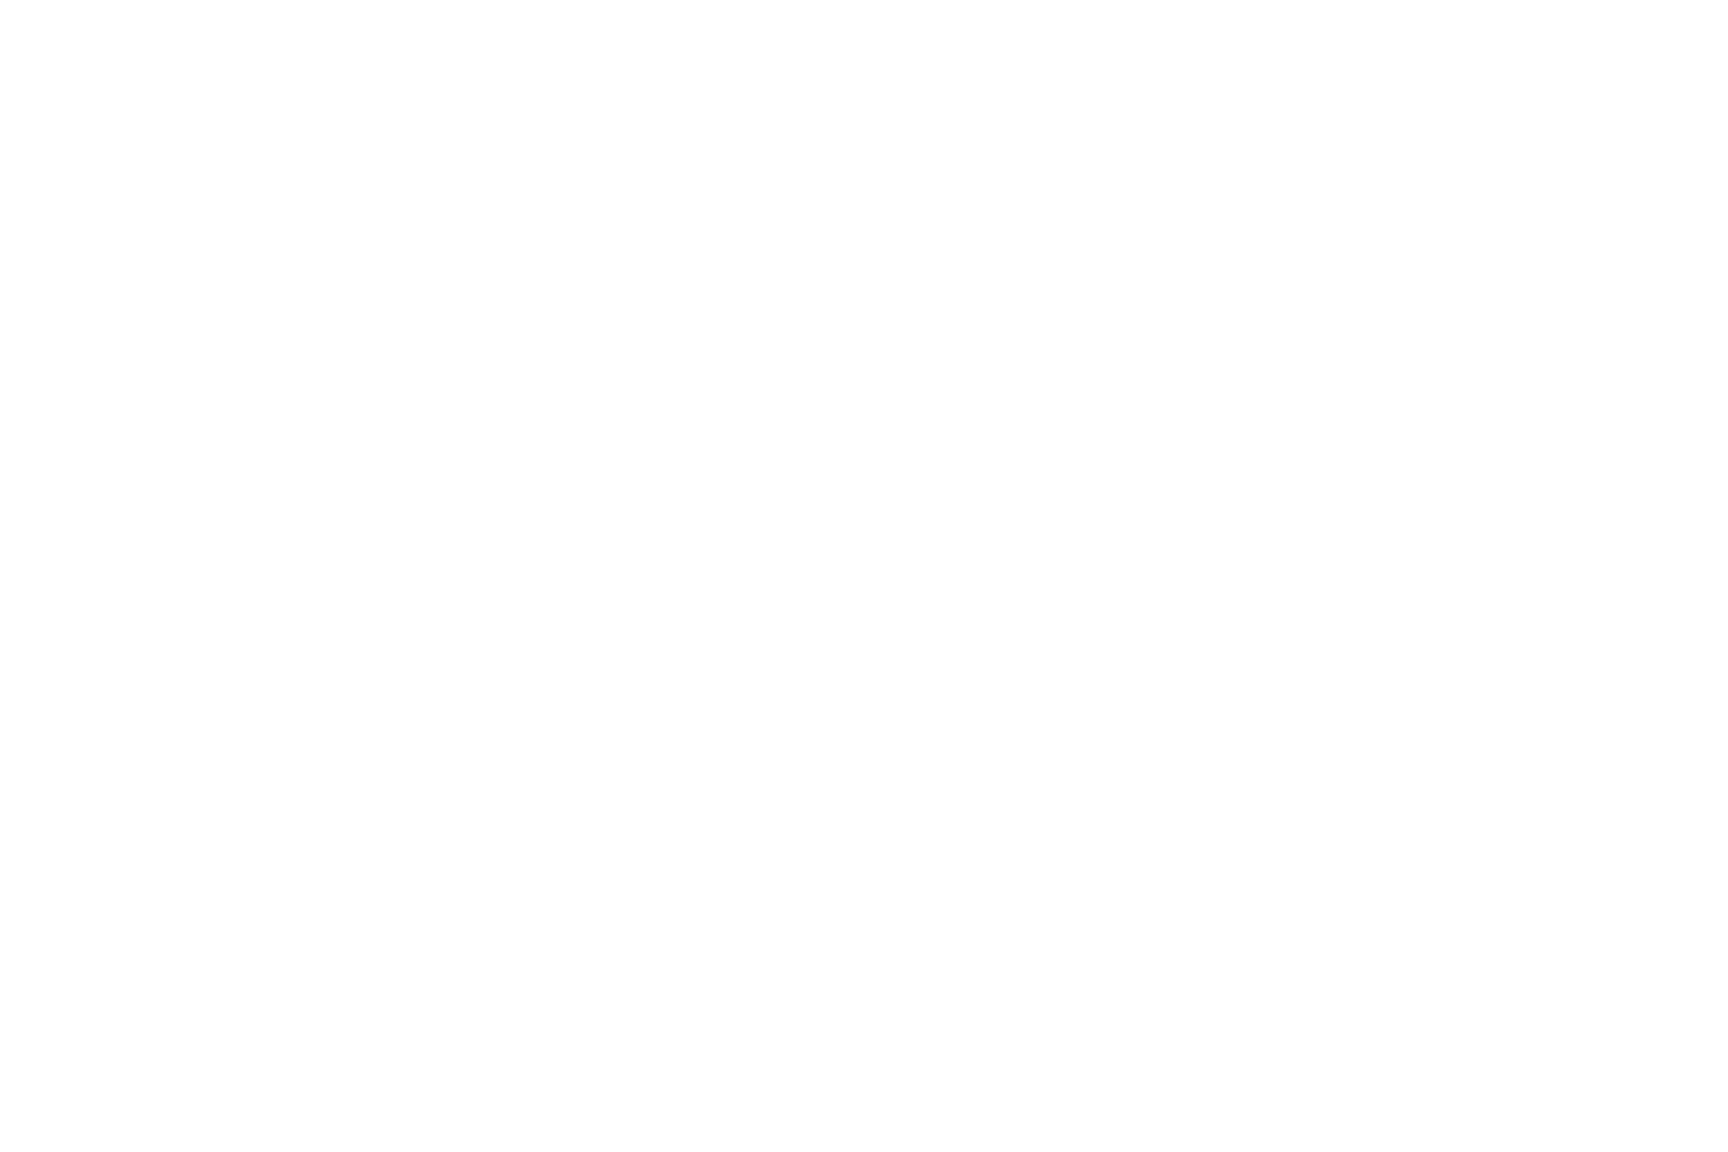

<IPython.core.display.Javascript object>


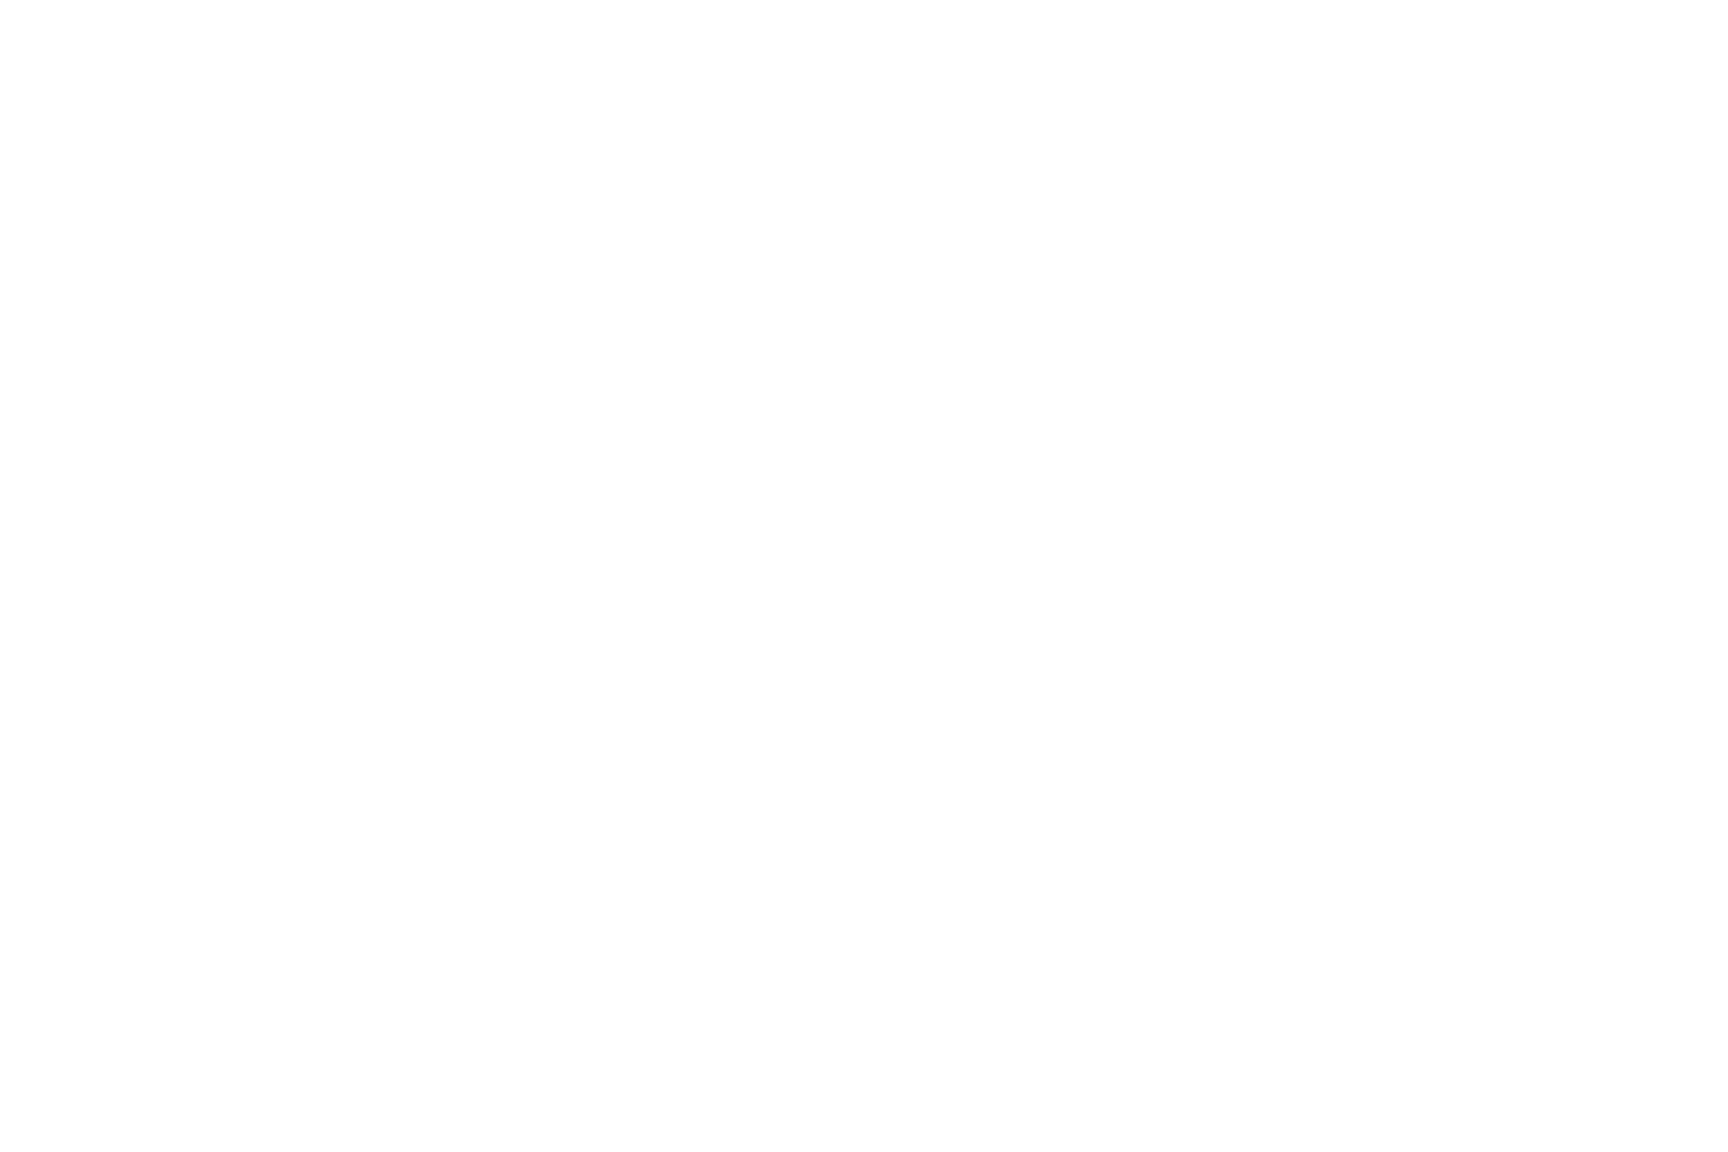

<IPython.core.display.Javascript object>


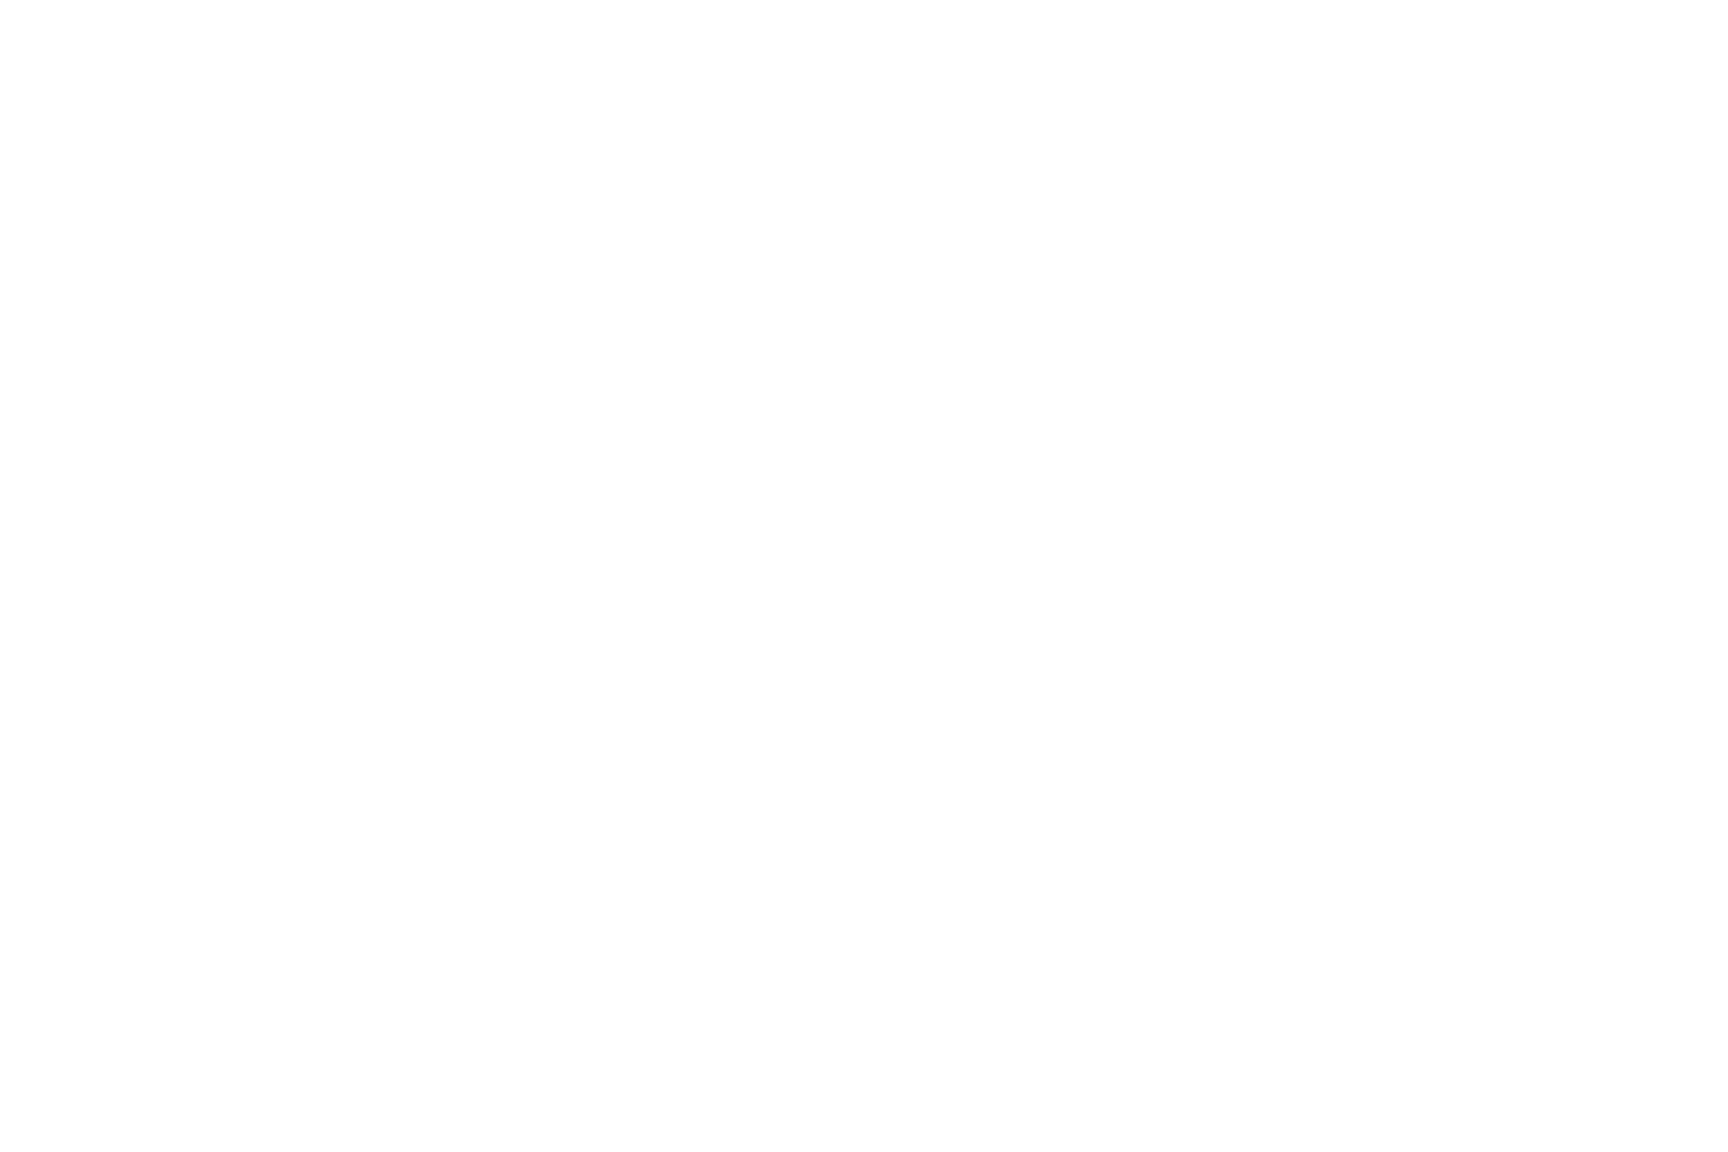

<IPython.core.display.Javascript object>


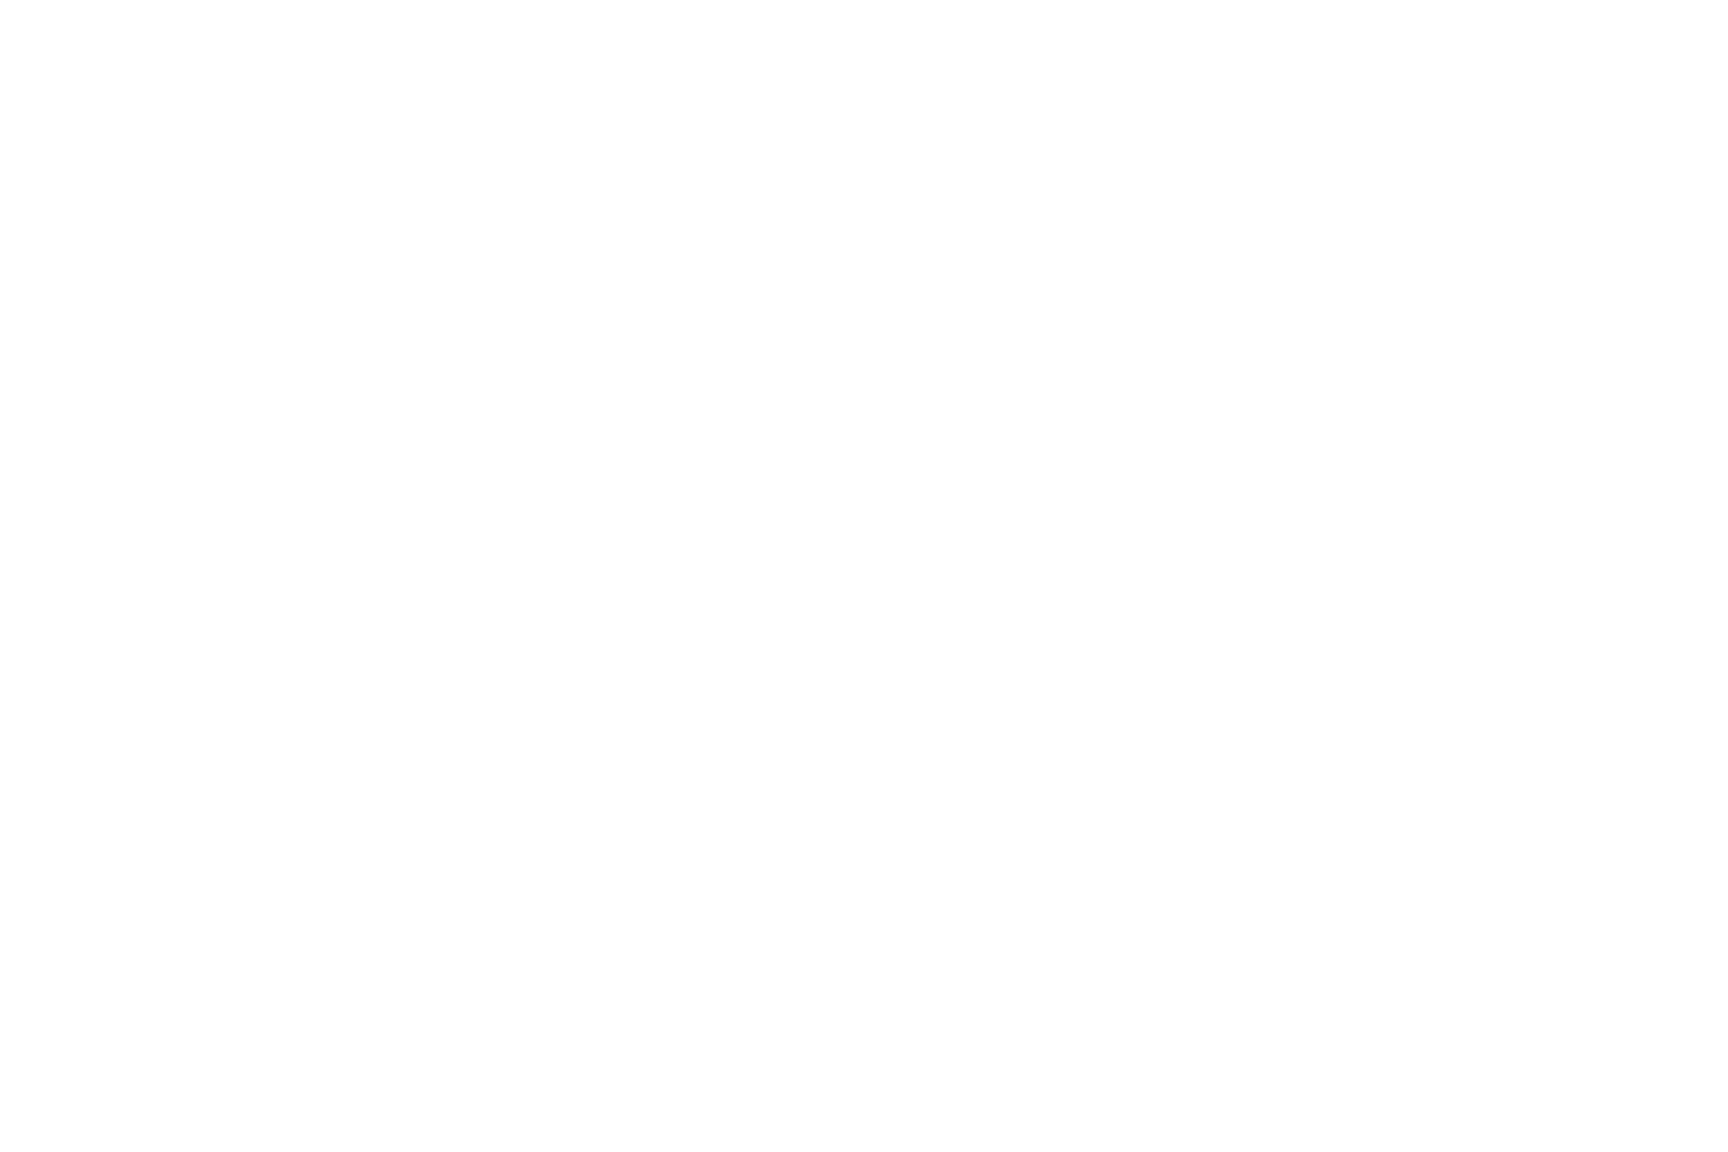

<IPython.core.display.Javascript object>


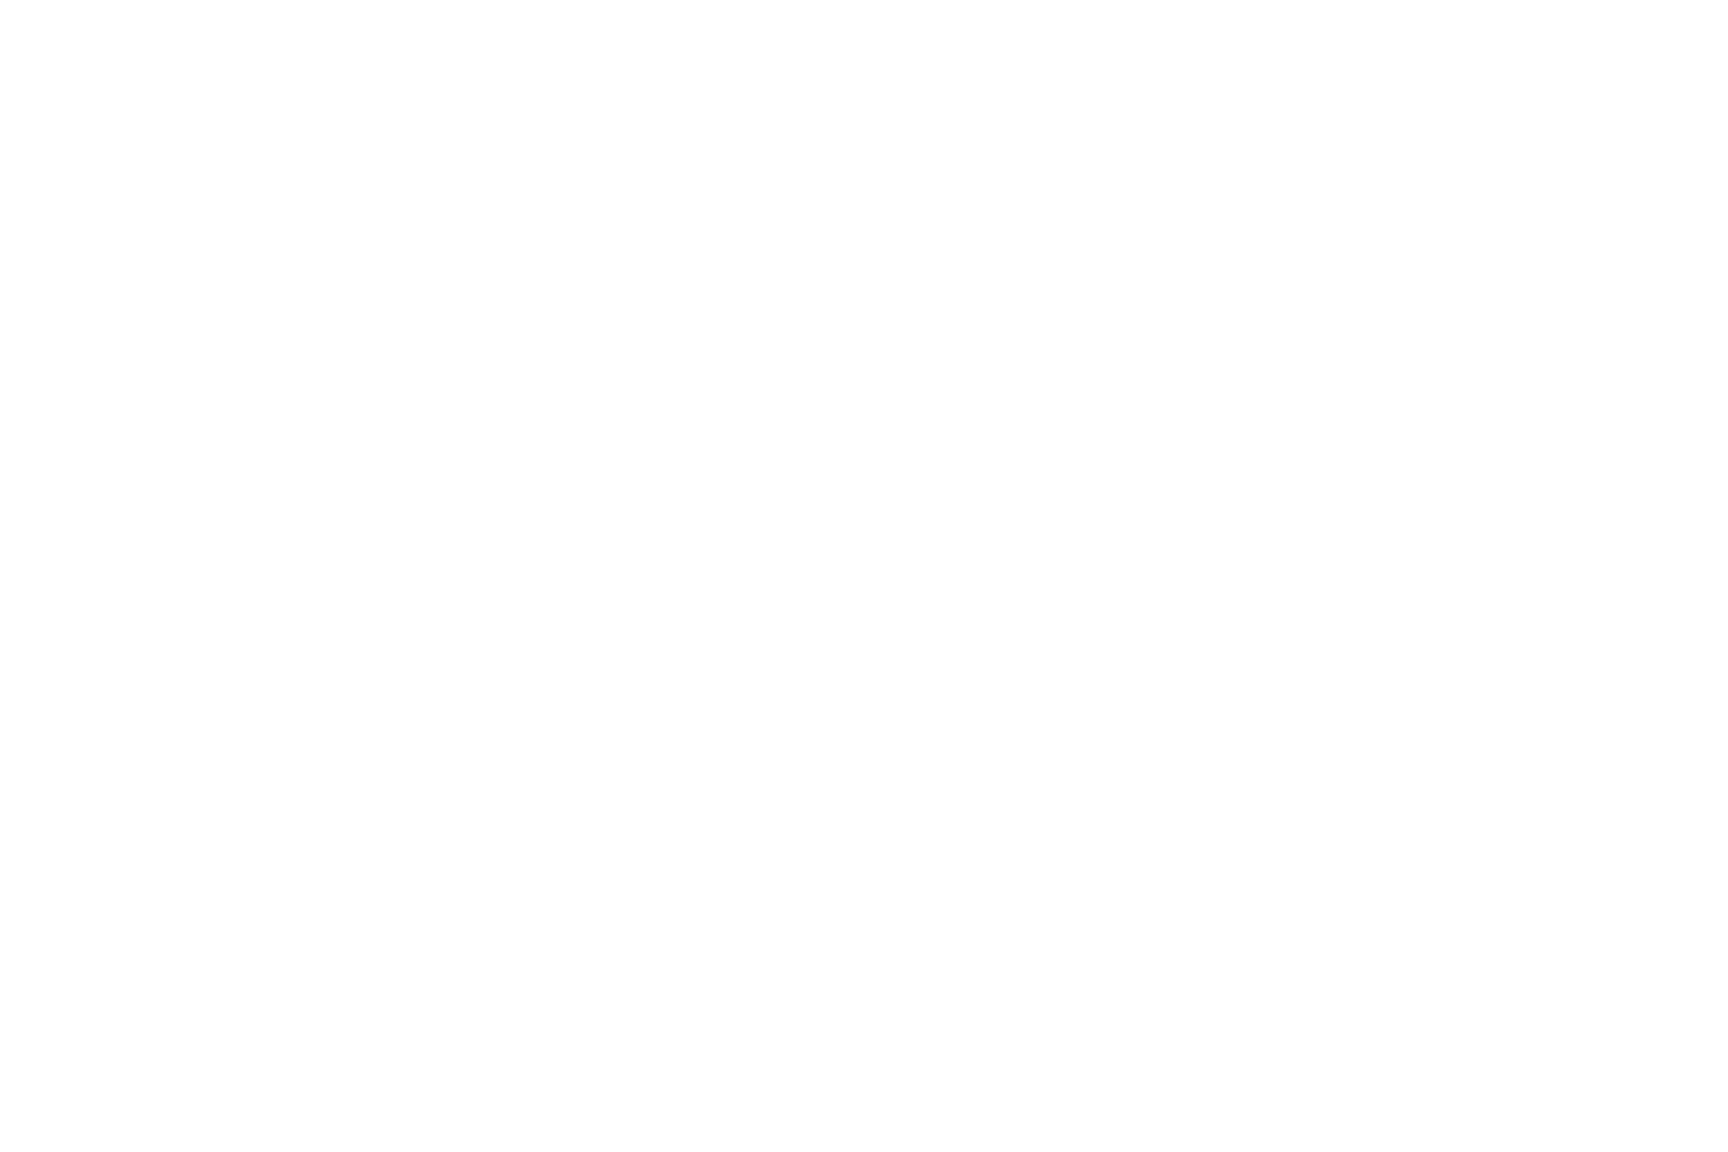

In [113]:
%matplotlib notebook

from keras.optimizers import Adam, Nadam, RMSprop
import talos as ta

p = {
     'lr': [0.001, 0.002, 0.004],
     'n_samples': [4700],
     'n_units': [16, 20, 24],
#      'batch_size': [10, 100, 1000],
     'batch_size': [100],
     'epochs': [100],
     # 'dropout': (0, 0.5, 5),
     # 'weight_regulizer':[None],
     # 'emb_output_dims': [None],
     # 'shape':['brick','long_funnel'],
     'optimizer': [Adam],
 }

# 'lr': 0.004,
# 'n_samples': 44000 * 3,
# 'n_units': 20,
# 'batch_size': 500,
# 'epochs': 100,
# 'optimizer': keras.optimizers.Adam,
        
# and run the experiment
t = ta.Scan(x=X_tr_s[:np.max(p['n_samples'])],
            y=y_tr_s[:np.max(p['n_samples'])],
            model=create_and_train_model,
#             grid_downsample=0.5,
            params=p)

globals().update(locals())

In [114]:
r = ta.Reporting(t)
r.data.sort_values(by='loss')


,round_epochs,loss,lr,batch_size,epochs,lr,n_samples,n_units,optimizer
7,100,0.064101,0.00256,100,100,0.004,4700,20,<class 'keras.optimizers.Adam'>
8,100,0.073632,0.00256,100,100,0.004,4700,24,<class 'keras.optimizers.Adam'>
6,100,0.085991,0.00256,100,100,0.004,4700,16,<class 'keras.optimizers.Adam'>
3,100,0.088374,0.00128,100,100,0.002,4700,16,<class 'keras.optimizers.Adam'>
5,100,0.096870,0.00128,100,100,0.002,4700,24,<class 'keras.optimizers.Adam'>
4,100,0.106031,0.00128,100,100,0.002,4700,20,<class 'keras.optimizers.Adam'>
0,100,0.117395,0.00064,100,100,0.001,4700,16,<class 'keras.optimizers.Adam'>
2,100,0.124886,0.00064,100,100,0.001,4700,24,<class 'keras.optimizers.Adam'>
1,100,0.126163,0.00064,100,100,0.001,4700,20,<class 'keras.optimizers.Adam'>


In [115]:
best_params = r.data.loc[7]
best_params

round_epochs                                100
loss                                  0.0641015
lr                                      0.00256
batch_size                                  100
epochs                                      100
lr                                        0.004
n_samples                                  4700
n_units                                      20
optimizer       <class 'keras.optimizers.Adam'>
Name: 7, dtype: object

In [116]:
type(best_params)

pandas.core.series.Series

{'lr': 0.003, 'n_samples': 18800, 'n_units': 20, 'batch_size': 400, 'epochs': 300, 'optimizer': <class 'keras.optimizers.Adam'>}


<IPython.core.display.Javascript object>


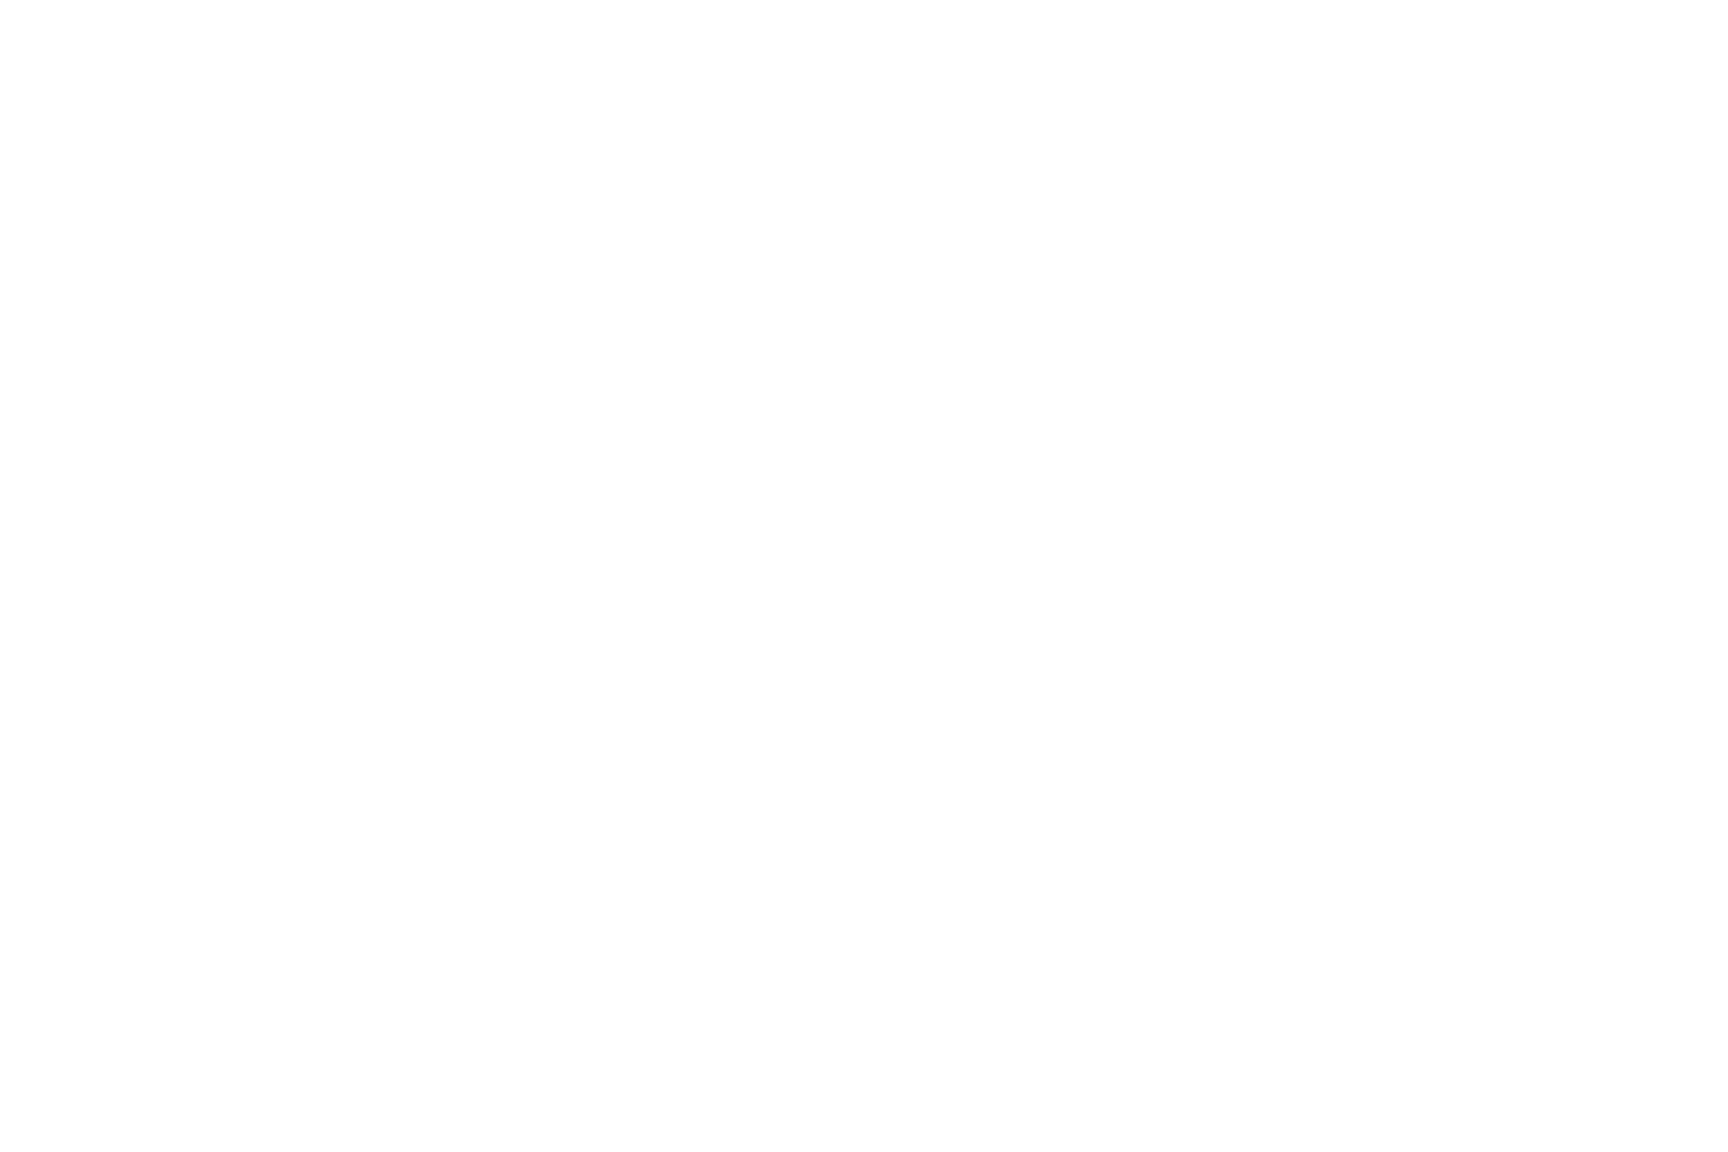

Epoch 1/300
18800/18800 [==============================] - 1s 59us/step - loss: 0.4550
Epoch 2/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.4039
Epoch 3/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.3791
Epoch 4/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.3700
Epoch 5/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.3646
Epoch 6/300
18800/18800 [==============================] - 0s 27us/step - loss: 0.3142
Epoch 7/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.2560
Epoch 8/300
18800/18800 [==============================] - 1s 27us/step - loss: 0.2605
Epoch 9/300
18800/18800 [==============================] - 1s 27us/step - loss: 0.2297
Epoch 10/300
18800/18800 [==============================] - 1s 27us/step - loss: 0.2072
Epoch 11/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.2054
Epoch 12/300
18800/18800 [===============

18800/18800 [==============================] - 0s 26us/step - loss: 0.0580
Epoch 187/300
18800/18800 [==============================] - 1s 27us/step - loss: 0.0658
Epoch 188/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.0637
Epoch 189/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.0710
Epoch 190/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.0691
Epoch 191/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.0631
Epoch 192/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.0738
Epoch 193/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.0660
Epoch 194/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.0578
Epoch 195/300
18800/18800 [==============================] - 0s 26us/step - loss: 0.0580
Epoch 196/300
18800/18800 [==============================] - 0s 25us/step - loss: 0.0594
Epoch 197/300
18800/18800 [========

<IPython.core.display.Javascript object>


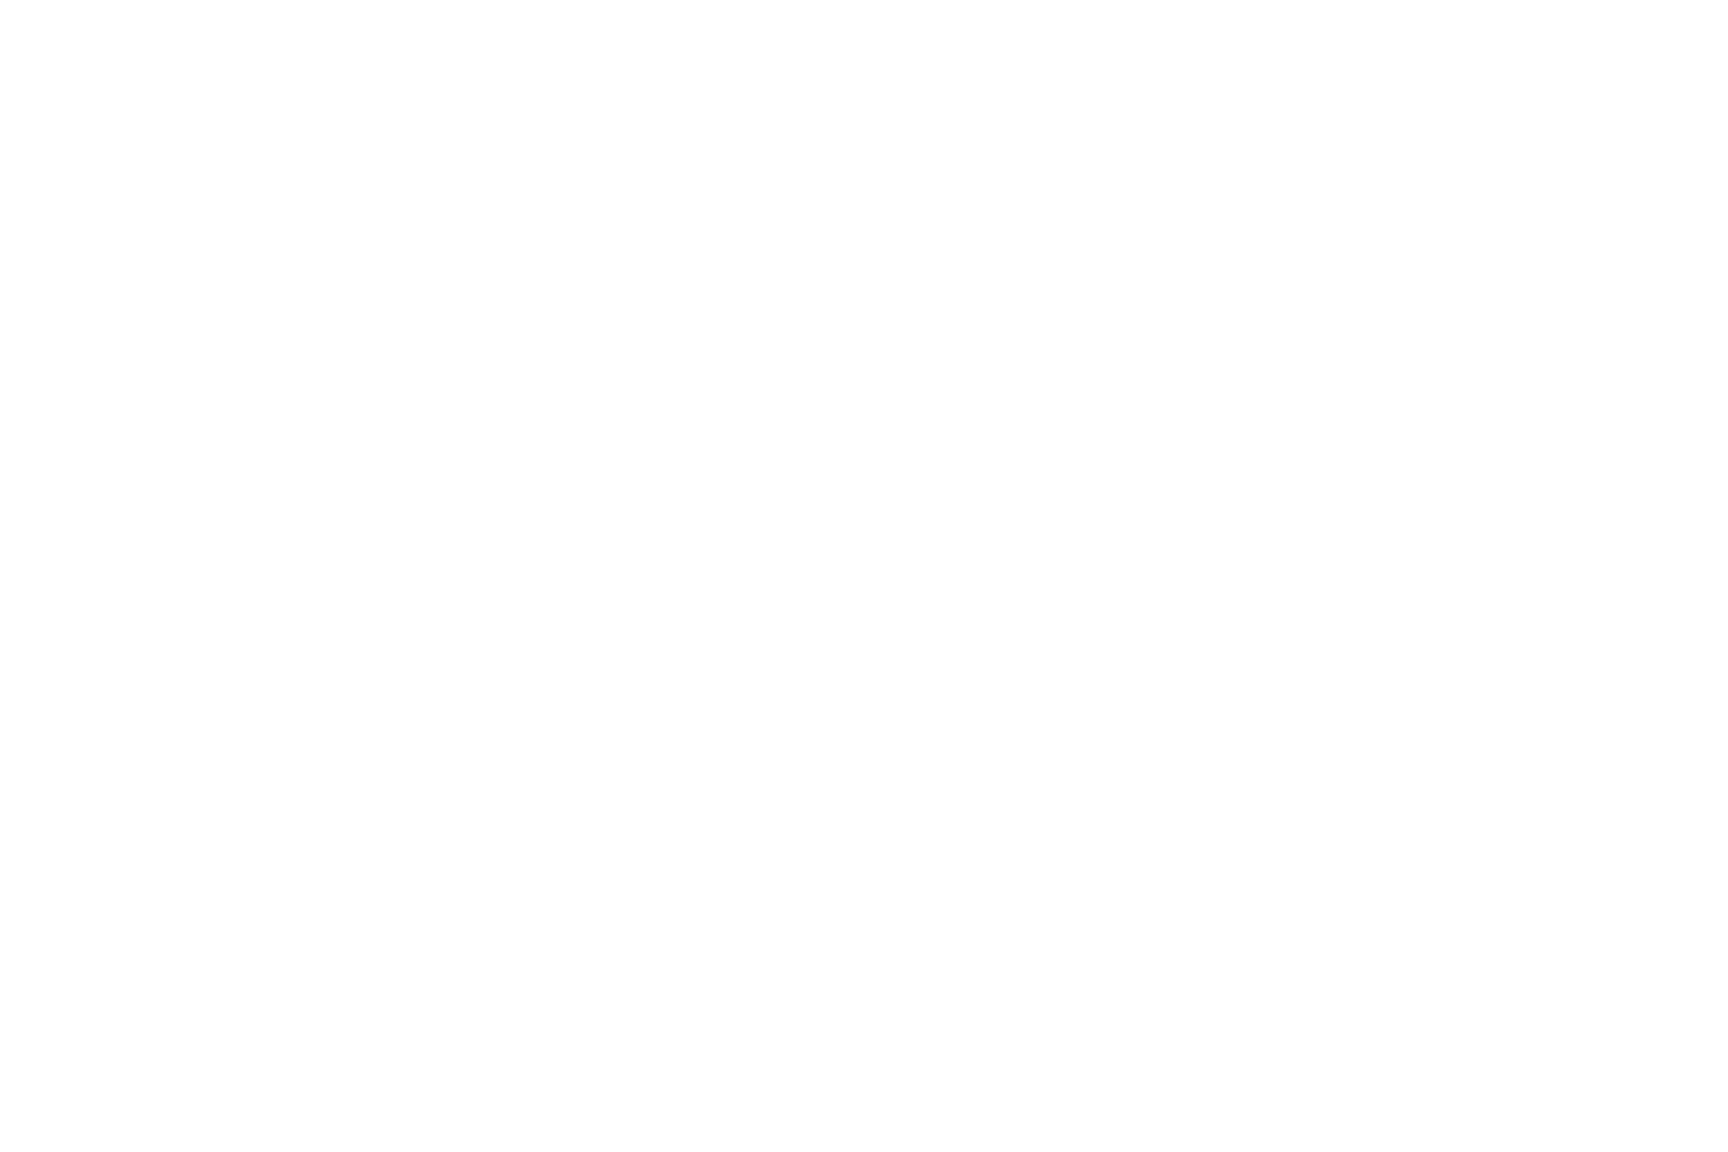

In [141]:
%%time
%matplotlib notebook

best_params = {
    'lr': 0.003,
    'n_samples': 18800,
    'n_units': 20,
    'batch_size': 400,
    'epochs': 300,
    'optimizer': keras.optimizers.Adam,
}


# model = load_model('saved_models/02_peak_comp_60_samples_180_params.h5')
model = create_model(best_params)

history, model = train_model(
    model,
    X_tr_s[:best_params['n_samples']],
    y_tr_s[:best_params['n_samples']],
    X_te_s[:best_params['n_samples']],
    y_te_s[:best_params['n_samples']],
    best_params,
    verbose_fit=1,
)

globals().update(locals())

In [142]:
MAGIC_OFFSET = 300

In [119]:
for layer in model.layers:
    weights = layer.get_weights() # list of numpy arrays
    print(weights)
    print('='*20)

[]
[array([[-5.3966969e-01, -1.1118026e+00, -6.5214407e-01,  9.0467781e-02,
        -7.2235221e-01,  4.8260581e-01, -6.0605955e-01, -1.3842185e-01,
        -2.6061434e-01,  8.8304833e-02,  1.1011589e-01,  2.7973908e-01,
         6.1423957e-01, -2.1717407e-01,  8.3118761e-01, -3.7578928e-01,
         6.8726093e-01, -6.4631248e-01,  1.5613700e+00,  5.1278162e-01,
        -4.3729395e-01, -3.6117285e-01,  6.4227974e-01,  4.5263919e-01,
         4.3617183e-01, -3.8658321e-02, -4.8670745e-01,  3.1484744e-01,
        -1.3100272e+00, -2.2906752e-01, -8.6041123e-01,  2.3242980e-01,
        -8.6732489e-01,  4.9291438e-01,  1.1274153e+00,  3.4383520e-01,
        -1.3006968e+00, -2.4181087e-01, -1.2096766e+00,  1.9387510e-01,
        -1.5844928e+00,  5.6355624e-03,  8.0028266e-01, -1.6290908e-01,
        -2.8568128e-01,  3.6738940e-02, -1.3105153e+00,  7.2539828e-05,
         4.2897728e-01,  7.4111395e-02,  1.2326586e+00,  7.1652941e-02,
         9.3506551e-01,  3.9850909e-02, -1.0747666e+00,  1.2

In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (400, 64, 3)              0         
_________________________________________________________________
cu_dnngru_7 (CuDNNGRU)       (400, 64, 20)             1500      
_________________________________________________________________
cu_dnngru_8 (CuDNNGRU)       (400, 20)                 2520      
_________________________________________________________________
dense_4 (Dense)              (400, 1)                  21        
Total params: 4,041
Trainable params: 4,041
Non-trainable params: 0
_________________________________________________________________


In [144]:
# model.save('saved_models/02_peak_comp_60_samples_180_params.h5')

In [145]:
score = model.evaluate(X_te_s[:6000], y_te_s[:6000], verbose=0, batch_size=best_params['batch_size'])
score

0.1430590125421683

In [146]:
0.1430590125421683
0.040487171824161824

0.040487171824161824

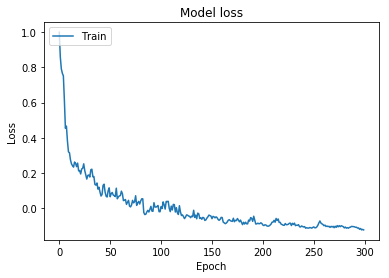

In [147]:
%matplotlib inline

from matplotlib import pyplot as plt

# Plot training & validation loss values
plt.plot(normalize(np.array(history.history['loss'])))
# plt.plot(normalize(np.array(history.history['val_loss'])))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [148]:
len(X_te_s)

6270

In [149]:
predict(model, X_te_s[:400], batch_size=best_params['batch_size'])

array([-3.26673016e-02, -2.87321676e-02, -2.45627817e-02, -2.01965719e-02,
       -1.51747428e-02, -9.37811658e-03, -2.98506953e-03,  3.67042795e-03,
        1.01334490e-02,  1.60607062e-02,  2.10725144e-02,  2.49650627e-02,
        2.74610706e-02,  2.82887444e-02,  2.72478685e-02,  2.38871537e-02,
        1.79629065e-02,  9.40227509e-03, -1.62251480e-03, -1.49054155e-02,
       -3.00541576e-02, -4.67844158e-02, -6.48136437e-02, -8.35980326e-02,
       -1.02546960e-01, -1.20736837e-01, -1.37228295e-01, -1.51180178e-01,
       -1.61608607e-01, -1.67859048e-01, -1.70312271e-01, -1.69584870e-01,
       -1.65985093e-01, -1.60412699e-01, -1.53748319e-01, -1.46815091e-01,
       -1.40032142e-01, -1.33349806e-01, -1.26414046e-01, -1.18676126e-01,
       -1.09776571e-01, -9.93636996e-02, -8.71754140e-02, -7.30098039e-02,
       -5.68052493e-02, -3.84814180e-02, -1.83037408e-02,  3.56291607e-03,
        2.67475061e-02,  5.07674031e-02,  7.48407841e-02,  9.79164243e-02,
        1.19097352e-01,  

In [178]:
print(X_tr_s[0][-1])

[-0.00759911  1.        ]


0   -0.232289
1   -0.237395
2   -0.242779
3   -0.248005
4   -0.251880
dtype: float32


Text(0,0.5,'value')

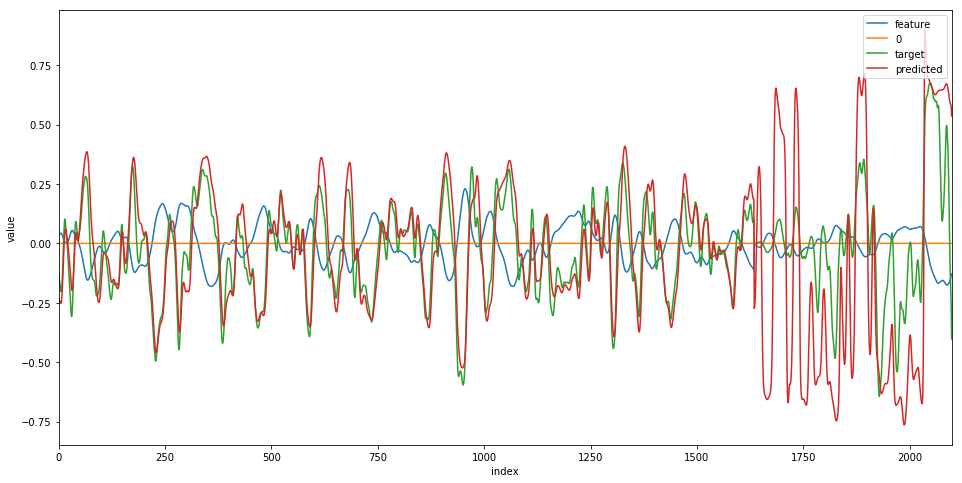

In [151]:
%matplotlib inline
from scipy.signal import savgol_filter

(fig, ax) = plt.subplots(figsize=(16, 8))

I = 2100
OFFSET = int(MAGIC_OFFSET) + 1200

X_to_test = X_te_s
y_to_test = y_te_s

feat = pd.Series((np.array(list(map(lambda row: row[-1][0], X_to_test[:(I + OFFSET)]))))[OFFSET:])

feat.plot.line(ax=ax, label='feature')

targ = pd.Series(y_to_test[OFFSET:(I + OFFSET)])

pred = pd.Series(predict(model, X_to_test[:(I + OFFSET)], batch_size=best_params['batch_size'])[OFFSET:])
# pred = (pred * 3.2) + 0.001
pred = pred + 0.001

zeros = pd.Series(np.zeros(I))
zeros.plot.line(ax=ax, label='0')

targ.plot.line(ax=ax, label='target')

print(pred[:5])

pred.plot.line(ax=ax, label='predicted')
# pd.Series(savgol_filter(pred, 5, 3)).plot.line(ax=ax, label='savgol(predicted)')

# pd.Series(normalize(np.array(list(map(lambda w: w[-1], X_te_f[:I]))))).plot.line(ax=ax, label='feature')

ax.legend(loc="upper right")
ax.set_xlabel('index')
ax.set_ylabel('value')


## Time to evaluate performance

In [152]:
# X_to_repeat = X_tr_s[:int(44000 * 2.8)]
# X_to_pred = np.concatenate([X_to_repeat, X_to_repeat, X_to_repeat])
# len(X_to_pred) / 44000, X_to_pred[0][:4], X_to_pred[1][:4]

In [154]:
def mapper(a):
    i = a[0]
    row = a[1]
    
    t = i / len(X_to_pred)
    gain = 1.0 * (1 - t) + 6.4 * t
    
    return np.array(list(map(lambda x: [x[0], gain], row)))

# X_to_pred = np.array(list(map(mapper, enumerate(X_to_pred))))

# X_to_pred[0][:5], X_to_pred[1][:5], X_to_pred[-2][:5], X_to_pred[-1][:5]

In [193]:
X_to_pred = X_te_s

In [194]:
predictions = predict(model, X_to_pred, batch_size=best_params['batch_size'], verbose=1)
len(predictions), predictions[:10], np.max(predictions), np.min(predictions)

175600/175600 [==============================] - 1s 8us/step


(175600,
 array([-0.02404951, -0.0245495 , -0.02338341, -0.02046203, -0.01602028,
        -0.01037441, -0.00395075,  0.00278512,  0.00927514,  0.01513418],
       dtype=float32),
 0.9278304,
 -1.2123002)

In [197]:
np.min(y_te_s)

-0.7874996

In [198]:
predictions_n = np.clip((predictions / 1.2) * 0.8, -1.0, 1.0) * MAX_VALUE
len(predictions_n), predictions_n[:10], np.max(predictions_n), np.min(predictions_n)

(175600, array([-525.3535 , -536.2756 , -510.80267, -446.98627, -349.95767,
        -226.62556,  -86.30278,   60.83994,  202.6124 ,  330.60107],
       dtype=float32), 20268.145, -26482.291)

In [199]:
wavfile.write('output/pred_out_gr_jump_head_gain_2_params_v1.wav', source_fs, predictions)

In [200]:
len(predictions) / 44000

3.9909090909090907